In [18]:
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import random                      # import basic random number generator functions
%config InlineBackend.figure_format = 'retina'
from scipy.signal import hilbert
from scipy import signal
import time
from ipywidgets import interactive,interact, HBox, Layout,VBox
from scipy.signal import find_peaks
from matplotlib import gridspec

In [9]:
def F(x,a,theta): 
    """Population activation function.

    Arguments:
    x -- the population input
    a -- the gain of the function
    theta -- the threshold of the function
    
    Returns:
    y -- the population activation response
    """
    # y = (1+np.exp(-a*(x-theta)))**-1 - (1+np.exp(a*theta))**-1
    y = a*(1+np.exp(-4*x/a)*(a-theta)/theta)**-1
    return y
def F_inv(x,a,theta): 
    """Define the inverse of the population activation function.

    Arguments:
    x -- the population input
    a -- the gain of the function
    theta -- the threshold of the function
    
    Returns:
    y -- value of the inverse function
    """
    y = -1/a * np.log((x+(1+np.exp(a*theta))**-1)**-1 -1) + theta
    
    return y

In [10]:
def get_E_nullcline(E):
    """Solve for I along the E nullcline (dE/dt = 0).
   
    Arguments:
    E -- values of E over which the nullcline is computed
    
    Returns:
    I -- values of I along the nullcline for each E
    """
    I = 1./wEI*(wEE*E+I_extE-F_inv(E/(1-r*E),a_E,theta_E))
    
    return I
  
  
def get_I_nullcline(I):
    """Solve for E along the I nullcline (dI/dt = 0).
   
    Arguments:
    I -- values of I over which the nullcline is computed
    
    Returns:
    E -- values of E along the nullcline for each I
    """
    E = 1./wIE*(wII*I-I_extI+F_inv(I/(1-r*I),a_I,theta_I))
    
    return E
def plot_phase():
 
   E = np.linspace(-0.01,.48,100)
   E_nullcline = get_E_nullcline(E)

   plt.figure()
   plt.plot(E,E_nullcline,'r')

   I = np.linspace(-.01,.3,100)
   I_nullcline = get_I_nullcline(I)
   plt.plot(I_nullcline,I,'b')
   plt.xlabel('E')
   plt.ylabel('I')
   plt.legend(['E nullcline','I nullcline'])
   for E_s in np.arange(-0.1,1.1,0.1):
    for I_s in np.arange(-0.1,1.1,0.1):
        d_E=(-E_s+(1-r*E_s)*F(wEE*E_s-wEI*I_s+I_extE,a_E,theta_E))/tau_E
        d_I=(-I_s+(1-r*I_s)*F(wIE*E_s-wII*I_s+I_extI,a_I,theta_I))/tau_I
        #plt.arrow(E_s, I_s, d_E, d_I,length_includes_head=True,head_width=0.25, head_length=0.5, fc='r', ec='b')
        plt.quiver(E_s, I_s, d_E, d_I, scale=15,color='c',alpha=0.3)

In [11]:
def calculate_LFP(t, E_syn, I_syn, NE=25, NI=565):

  """ calculate the LFP by the current
  t--time(vector)
  E--activity of excitatory population(vector)
  I--activity of inhibitory population(vector)
  I_extE: the external input to excitatory population
  I_extI: the external input to inhibitory poopulation
  NE: the number of the excitatory neuron
  NI: the number of the inhibitory neuron

  return :
  LFP
  """
  LFP = np.zeros_like(t)
  LFP = NE*E_syn + NI*I_syn
  return LFP

In [12]:
def local_maximum_point(E):
    """ find all the local maximum point of E
    E: data of vector
    return the local maximum point and local maximum value
    """
    maximum_point=[]
    maximum=[]
    if E[0]>E[1]: 
        maximum_point.append(0)
        maximum.append(E[0])
    for i in range(len(E)-2):
        if (E[i+1]>E[i+2])& (E[i+1]>E[i]): 
            maximum_point.append(i+1)
            maximum.append(E[i+1])
    if E[-1]>E[-2]: 
       maximum_point.append(len(E)-1)
       maximum.append(E[-1])
    return  maximum_point, maximum

a=[1, 2, 3, 4]
idx,value=local_maximum_point(a)
print(idx)

def get_phase(beta_LFP,spikes):
    """ get the beta phase
    beta_LFP: beta wave, vector
    spike: the spike time, vector
    return the beta phase at the spike time
    """
    HT_beta = hilbert(beta_LFP)  # compute hilbert transformation
    if len(spikes) >= 1:

        phases_beta = np.angle(HT_beta[spikes]) # instantaneous phases at spike time of beta oscillations
        
        # convert into the range (0, 2pi]
        idx = np.where(phases_beta < 0.) 
        phases_beta[idx] = phases_beta[idx] + 2 * np.pi * np.ones(len(idx))
        
    else:
        phases_beta = []

    return phases_beta

def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True, show_mean = True, amp = 1.2):

    # Wrap angles to [-pi, pi)
    data = x
    
    x_mean = np.angle(np.exp(data * 1j).mean())
    #r_mean = abs(sum(np.exp(data * 1j)))
    
    x = (x+np.pi) % (2*np.pi) - np.pi
    
    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)
    
    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    #patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
    #                 edgecolor='C0', fill=False, linewidth=1)
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths, color='.8',
                      edgecolor = None,  linewidth=1)
    if show_mean:
        theta = [x_mean, x_mean]
        r = [0, radius.mean()]
        #r2 = [0, amp*radius.mean()]
        ax.plot(theta, r,'r')
        #ax.plot(theta, r2,alpha=0.01)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])
        
    #ax.set_ylim(0,amp)

    return n, bins, patches
    
def plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2):
    
    n=len(E0)
    E_phases=[]
    I_phases=[]
    for i in range(n):
      E,I,LFP,beta_LFP = simulate_wc(t,E0[i],I0[i])
      LFP=LFP[500:-1]          # delete the unstable state
      beta_LFP=beta_LFP[500:-1]          # delete the unstable state
      E=E[500:-1]          # delete the unstable state
      I=I[500:-1]          # delete the unstable state
      pointE,valueE = local_maximum_point(E)
      pointI,valueI = local_maximum_point(I)
      beta_LFP=beta_LFP+np.random.normal(0,1,len(beta_LFP))     #add noise
      beta_LFP=(beta_LFP-np.mean(beta_LFP))/np.std(beta_LFP)   # normalization
      phases_beta_E=get_phase(beta_LFP,pointE)
      phases_beta_I=get_phase(beta_LFP,pointI)
    #   phases_beta_E=get_phase(beta_LFP,np.arange(len(beta_LFP)))
    #   phases_beta_I=get_phase(beta_LFP,np.arange(len(beta_LFP)))
    #   LFP=LFP+np.random.normal(0,1,len(LFP))     #add noise
    #   LFP=(LFP-np.mean(LFP))/np.std(LFP)   # normalization
    #   phases_beta_E=get_phase(LFP,pointE)
    #   phases_beta_I=get_phase(LFP,pointI)
    #   phases_beta_E=get_phase(LFP,np.arange(len(beta_LFP)))
    #   phases_beta_I=get_phase(LFP,np.arange(len(beta_LFP)))
      E_phases = np.hstack((E_phases,phases_beta_E))
      I_phases = np.hstack((I_phases,phases_beta_I))

    fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,4))
    circular_hist(axs[0], E_phases, offset = 0, density = density, show_mean = show_mean,amp=amp)
    circular_hist(axs[1], I_phases, offset = 0, density = density, show_mean = show_mean,amp=amp)
    return E_phases,I_phases
    

[3]


In [13]:

def simulate_wc(prop,E0,I0):
  """Simulate the Wilson-Cowan equations.
   
  Arguments:
  t -- time (vector)
  E0 -- initial condition of the excitatory population
  I0 -- initial condition of the inhibitory population
  I_extE -- the external input to excitatory population
  I_extI -- the external input to inhibitory population
    
    
  Returns:
  E -- Activity of excitatory population (vector)
  I -- Activity of inhibitory population (vector)
  """
  dt=0.001
  t = np.arange(0,5,dt)
  delay_EE=int(0.007/dt)
  delay_EI=int(0.020/dt)#sensitive to E phase, right
  delay_IE=int(0.007/dt)
  delay_II=prop['delta_ii']


  # External input
  wEE=0.40
  wEI=0.592
  wIE=0.374
  wII=prop['wii']   # frequency decrease
  wES=0.63
  wIS=1.493

  # # inhibition of SNc
  # S_spon=5.83
  # S_stim=3.658

  # I_extE=-wES*S_stim
  # I_extI=-wIS*S_stim-2.0

  I_extE= prop['IE']
  I_extI=prop['II']

  # Excitatory parameters
  tau_E = 0.0078   # sensitive to the amplitude of the peak frequency

  # Inhibitory parameters
  r=0

  a_E=16 
  theta_E=6
  a_I=25
  theta_I=5    #sensitive to the firing rate of I

  tau0 = 0.002 # Noise time constant [sec]
  sigma = 0.02 # Noise magnitude [nA]
  I_noise= 1.5 # background current [nA]

  tau_I = 0.01243
  # tau_I=prop['tau_I']

  E = np.zeros(len(t))
  I = np.zeros(len(t))
  E_syn = np.zeros(len(t))
  I_syn = np.zeros(len(t))
  Ieta1 = np.zeros(len(t))
  Ieta2 = np.zeros(len(t))
  E[0] = E0
  I[0] = I0
  for k in range(len(t)-1):
    idx1=max(k-delay_EE,0)
    idx2=max(k-delay_EI,0)
    idx3=max(k-delay_IE,0)
    idx4=max(k-delay_II,0)
    E[k+1] = E[k] + dt/tau_E * (-E[k]+(1-r*E[k])*F(wEE*E[idx1]-wEI*I[idx2]+I_extE+Ieta1[k],a_E,theta_E))
    I[k+1] = I[k] + dt/tau_I * (-I[k]+(1-r*I[k])*F(wIE*E[idx3]-wII*I[idx4]+I_extI+Ieta2[k],a_I,theta_I))
    # E[k+1] = E[k] + dt/tau_E * (-E[k]+(1-r*E[k])*F(wEE*E[idx1]-wEI*I[idx2]+I_extE,a_E,theta_E))
    # I[k+1] = I[k] + dt/tau_I * (-I[k]+(1-r*I[k])*F(wIE*E[idx3]-wII*I[idx4]+I_extI,a_I,theta_I))
    E_syn[k+1] = wEE*E[idx1]-wEI*I[idx2]+I_extE+Ieta1[k]
    I_syn[k+1] = wIE*E[idx3]-wII*I[idx4]+I_extI+Ieta2[k]
    Ieta1[k+1] = Ieta1[k] + (dt/tau0) * (I_noise-Ieta1[k]) + np.sqrt(dt/tau0)*sigma*np.random.randn()
    Ieta2[k+1] = Ieta2[k] + (dt/tau0)*(I_noise-Ieta2[k]) + np.sqrt(dt/tau0)*sigma*np.random.randn()

   
  LFP = calculate_LFP(t, E_syn, I_syn, NE=25, NI=565)
  freqs,power=signal.welch(LFP, fs=1000.0, window='hann',nperseg=320,noverlap=250, nfft=800, scaling='density')

  
#   upfilter = 36
#   # calculate the beta wave 12.5-30
#   # b,a = signal.cheby2(N = 4, rs = upfilter, Wn = [12.5/ 500., 30. / 500.], btype = 'bandpass')
#   b,a = signal.butter(N = 4, Wn = [12.5, 30.], btype = 'bandpass',fs=1000)

#   # use band pass chebyshev-2 
#   beta_LFP = signal.filtfilt(b,a, LFP) # filter out beta band oscillations
  
  return E,I,freqs,power

def frequency_analysis(E,I,LFP,beta_LFP):
    
    dt = t[1]-t[0]
    plt.figure(figsize=(15,7))
    plt.subplot(2,3,1)
    plt.plot(t,E,'r')
    plt.plot(t,I,'b')
    plt.xlabel('t')
    plt.ylabel('E(t), I(t)')
    plt.legend(['E(t)','I(t)'],loc='best')

    plt.subplot(2,3,2)
    plt.plot(t,LFP,'r',label='LFP')
    plt.plot(t,beta_LFP,'b',label='beta wave')
    plt.legend()
  
    dl=320
    # dl=int(0.5/dt)
    plt.subplot(2,3,3)
    pxx2, freqs = plt.psd(LFP[:dl],  NFFT = 512,  Fs = 1./dt, scale_by_freq = True, noverlap = 250)
    plt.xlim([0,200])
    

  
    bins = int(len(LFP) / dl)
    for b in range(1, bins):
        start = dl * b
        end = dl * (b + 1)
        mid_pxx, mid_freq = plt.psd(LFP[start:end],  NFFT = 512, Fs = 1./dt, scale_by_freq = True, noverlap = 250)
        pxx2 = np.vstack((pxx2, mid_pxx))

    pxx2_mean = pxx2.mean(0)

    plt.subplot(2,3,4)
    plt.plot(freqs, pxx2_mean,'r',label = 'After Stimulus')
    plt.legend()
    plt.title('Power Spectral Density (dB/Hz)')
    plt.xlabel('Frequency')
    plt.xlim(xmin = 2, xmax = 70)
    plt.axvline(x=20, linestyle = '--')
    freqs0=freqs
    
    idx=np.argwhere(freqs>10)
    p_beta=pxx2_mean[idx]
    pmax=np.max(p_beta)
    fremax=np.argmax(p_beta)
    idx1=idx[fremax]
    fremax=freqs[idx1]
    print(pmax)
    print(fremax)
    

    
    plt.subplot(2,3,5)
    spec,freqs, t, cax = plt.specgram(LFP, NFFT = 512,Fs = 1./dt, scale = 'linear' ,
                                      scale_by_freq = True, noverlap = 500)
    plt.colorbar()
    plt.title('Time-Frequency Analysis')
    plt.ylim(ymin = 2, ymax = 40)
    plt.xlabel('Time (s)')
    return freqs0, pxx2_mean
  
def power_analysis(LFP,dt): 
    dl=320
    bins = int(len(LFP) / dl)
    pxx2, freqs = plt.psd(LFP[:dl],  NFFT = 512,  Fs = 1./dt, scale_by_freq = True, noverlap = 250)
    for b in range(1, bins):
        start = dl * b
        end = dl * (b + 1)
        mid_pxx, mid_freq = plt.psd(LFP[start:end],  NFFT = 512, Fs = 1./dt, scale_by_freq = True, noverlap = 250)
        pxx2 = np.vstack((pxx2, mid_pxx))
    pxx2_mean = pxx2.mean(0)
    return pxx2_mean,freqs

def max_power(freqs,power):
    idx=np.argwhere(freqs>10)
    p_beta=power[idx]
    pmax=np.max(p_beta)
    fremax=np.argmax(p_beta)
    idx1=idx[fremax]
    fremax=freqs[idx1]
    return fremax,pmax

In [53]:
# compare the oscillation frequency obtained from analysis and simulations
delta_ii0=np.arange(3,40,1)
wii0=np.arange(2,50,1)
prop={'delta_ii':34,
    'wii':9.2,
    'IE':90,
    'II':50}
oscillation_freq=np.zeros((len(delta_ii0),len(wii0)))
oscillation_power=np.zeros((len(delta_ii0),len(wii0)))
for i in range(len(delta_ii0)):
    prop['delta_ii']=delta_ii0[i]
    for j in range(len(wii0)):
        prop['wii']=wii0[j]
        E,I,freqs,power=simulate_wc(prop,0,0)
        oscillation_freq[i,j]=freqs[np.argmax(power)]
        oscillation_power[i,j]=np.max(power)


# xmin=0.003
# xmax=0.04
# ymin=2
# ymax=50
# wII_tol=np.arange(ymin,ymax,1)
# tII_tol=np.arange(xmin,xmax,0.001)
# w2=np.zeros((len(tII_tol),len(wII_tol)))
# tau_I=np.zeros((len(tII_tol),len(wII_tol)))
# for i in range(len(tII_tol)):
#     tII=tII_tol[i]
#     for j in range(len(wII_tol)):
#         wII=wII_tol[j]
#         w2[i,j]=np.arccos(-1/wII)/tII
#         tau_I[i,j]=((wII**2-1)/(w2[i,j]**2))**0.5
# w2=w2/(2*np.pi)
# im=plt.imshow(tau_I,origin='lower', aspect='auto',cmap='jet', vmin=None, vmax=0.5,
#             extent=[ymin, ymax, xmin, xmax])


In [25]:
# the dependece of oscillation frequency on parameters analysis
xmin=0.003
xmax=0.04
ymin=2
ymax=50
wII_tol=np.arange(ymin,ymax,1)
tII_tol=np.arange(xmin,xmax,0.001)
w2=np.zeros((len(tII_tol),len(wII_tol)))
tau_I=np.zeros((len(tII_tol),len(wII_tol)))
for i in range(len(tII_tol)):
    tII=tII_tol[i]
    for j in range(len(wII_tol)):
        wII=wII_tol[j]
        w2[i,j]=np.arccos(-1/wII)/tII
        tau_I[i,j]=((wII**2-1)/(w2[i,j]**2))**0.5
w2=w2/(2*np.pi)


Text(0.5, 1.0, 'analysis')

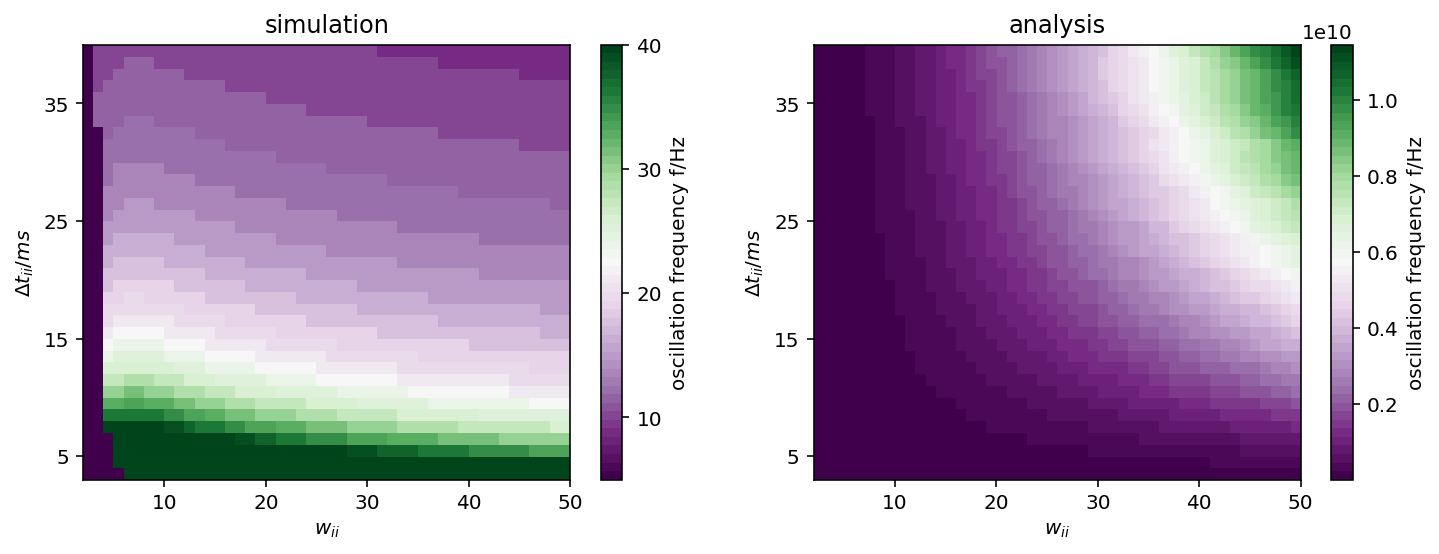

In [52]:
# ymin=delta_ii0[0]
# ymax=delta_ii0[-1]
# xmin=wii0[0]
# xmax=wii0[-1]
xmin=0.003*1000
xmax=0.04*1000
ymin=2
ymax=50
oscillation_freq[oscillation_freq==5]=0
fig = plt.figure(figsize=(12,4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
ax2=plt.subplot(gs[0]) 
im=ax2.imshow(oscillation_freq,origin='lower', aspect='auto',cmap=plt.get_cmap('PRGn',51), vmin=5, vmax=40,
            extent=[ymin, ymax, xmin, xmax])
bar=plt.colorbar(im)
# plt.get_cmap('PRGn',51)
ax2.set_xlabel(r'$w_{ii}$')
ax2.set_ylabel(r'$\Delta t_{ii}/ms$')
ax2.set_xticks(np.arange(10,60,10))
# ax2.set_yticks(np.arange(5,40,10))
ax2.set_yticks(np.arange(xmin+2,xmax,10))
ax2.set_xlim([2,50])
# ax2.set_ylim([3,40])
ax2.set_title('simulation')
bar.set_label('oscillation frequency f/Hz')
bar.set_ticks(np.arange(0,50,10))

ax1=plt.subplot(gs[1]) 
im=ax1.imshow(oscillation_power,origin='lower', aspect='auto',cmap=plt.get_cmap('PRGn',51), vmin=None, vmax=None,
            extent=[ymin, ymax, xmin, xmax])
bar=plt.colorbar(im)
# plt.get_cmap('PRGn',51) or jet
ax1.set_xlabel(r'$w_{ii}$')
ax1.set_ylabel(r'$\Delta t_{ii}/ms$')
ax1.set_yticks(np.arange(xmin+2,xmax,10))
bar.set_label('oscillation frequency f/Hz')
ax1.set_title('analysis')
# bar.set_ticks(np.arange(0,50,10))
# bar.set_label(r'$\tau_I/s$')
# plt.savefig('tau.eps')
# plt.savefig('oscillation frequency.eps')

# print((np.arccos(-1/50)/0.003)/2/np.pi)

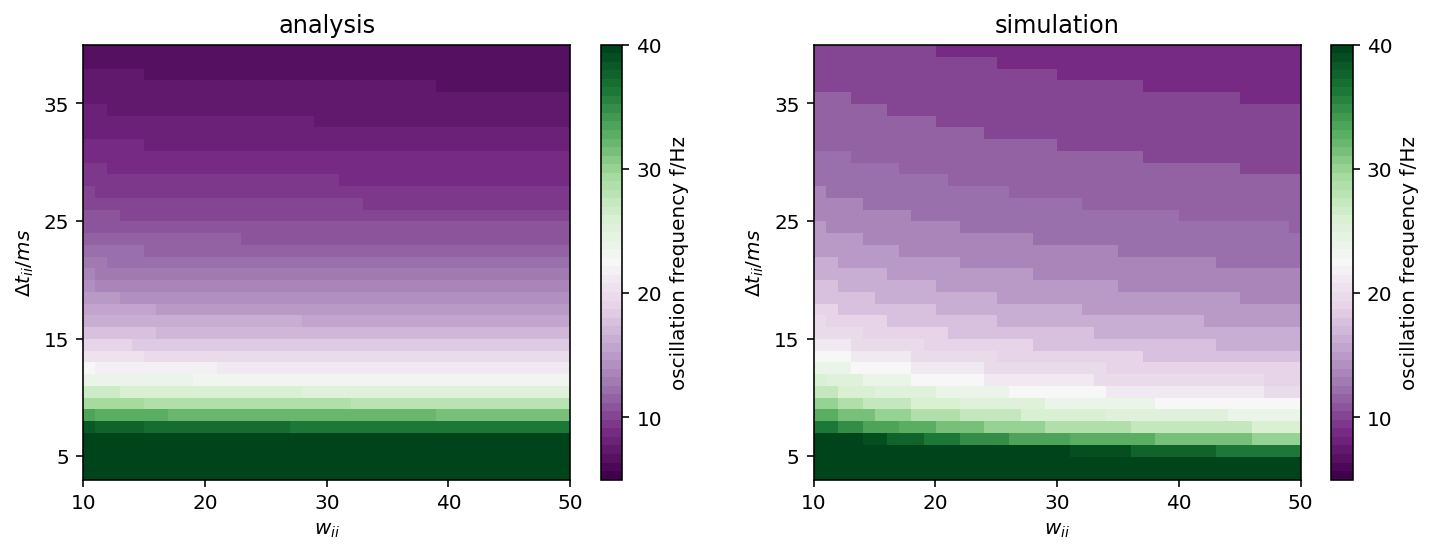

In [55]:
# ymin=delta_ii0[0]
# ymax=delta_ii0[-1]
# xmin=wii0[0]
# xmax=wii0[-1]
xmin=0.003*1000
xmax=0.04*1000
ymin=2
ymax=50
oscillation_freq[oscillation_freq==5]=0
fig = plt.figure(figsize=(12,4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
ax2=plt.subplot(gs[1]) 
im=ax2.imshow(oscillation_freq,origin='lower', aspect='auto',cmap=plt.get_cmap('PRGn',51), vmin=5, vmax=40,
            extent=[ymin, ymax, xmin, xmax])
bar=plt.colorbar(im)
# plt.get_cmap('PRGn',51)
ax2.set_xlabel(r'$w_{ii}$')
ax2.set_ylabel(r'$\Delta t_{ii}/ms$')
ax2.set_xticks(np.arange(10,60,10))
# ax2.set_yticks(np.arange(5,40,10))
ax2.set_yticks(np.arange(xmin+2,xmax,10))
ax2.set_xlim([10,50])
# ax2.set_ylim([3,40])
ax2.set_title('simulation')
bar.set_label('oscillation frequency f/Hz')
bar.set_ticks(np.arange(0,50,10))

ax1=plt.subplot(gs[0]) 
im=ax1.imshow(w2,origin='lower', aspect='auto',cmap=plt.get_cmap('PRGn',51), vmin=5, vmax=40,
            extent=[ymin, ymax, xmin, xmax])
bar=plt.colorbar(im)
# plt.get_cmap('PRGn',51) or jet
ax1.set_xlabel(r'$w_{ii}$')
ax1.set_ylabel(r'$\Delta t_{ii}/ms$')
ax1.set_xticks(np.arange(10,60,10))
ax1.set_yticks(np.arange(xmin+2,xmax,10))
bar.set_label('oscillation frequency f/Hz')
ax1.set_xlim([10,50])
ax1.set_title('analysis')
bar.set_ticks(np.arange(0,50,10))
# bar.set_label(r'$\tau_I/s$')
# plt.savefig('tau.eps')
plt.savefig('oscillation frequency.eps')

# print((np.arccos(-1/50)/0.003)/2/np.pi)


763661.9828321525
[11.71875]


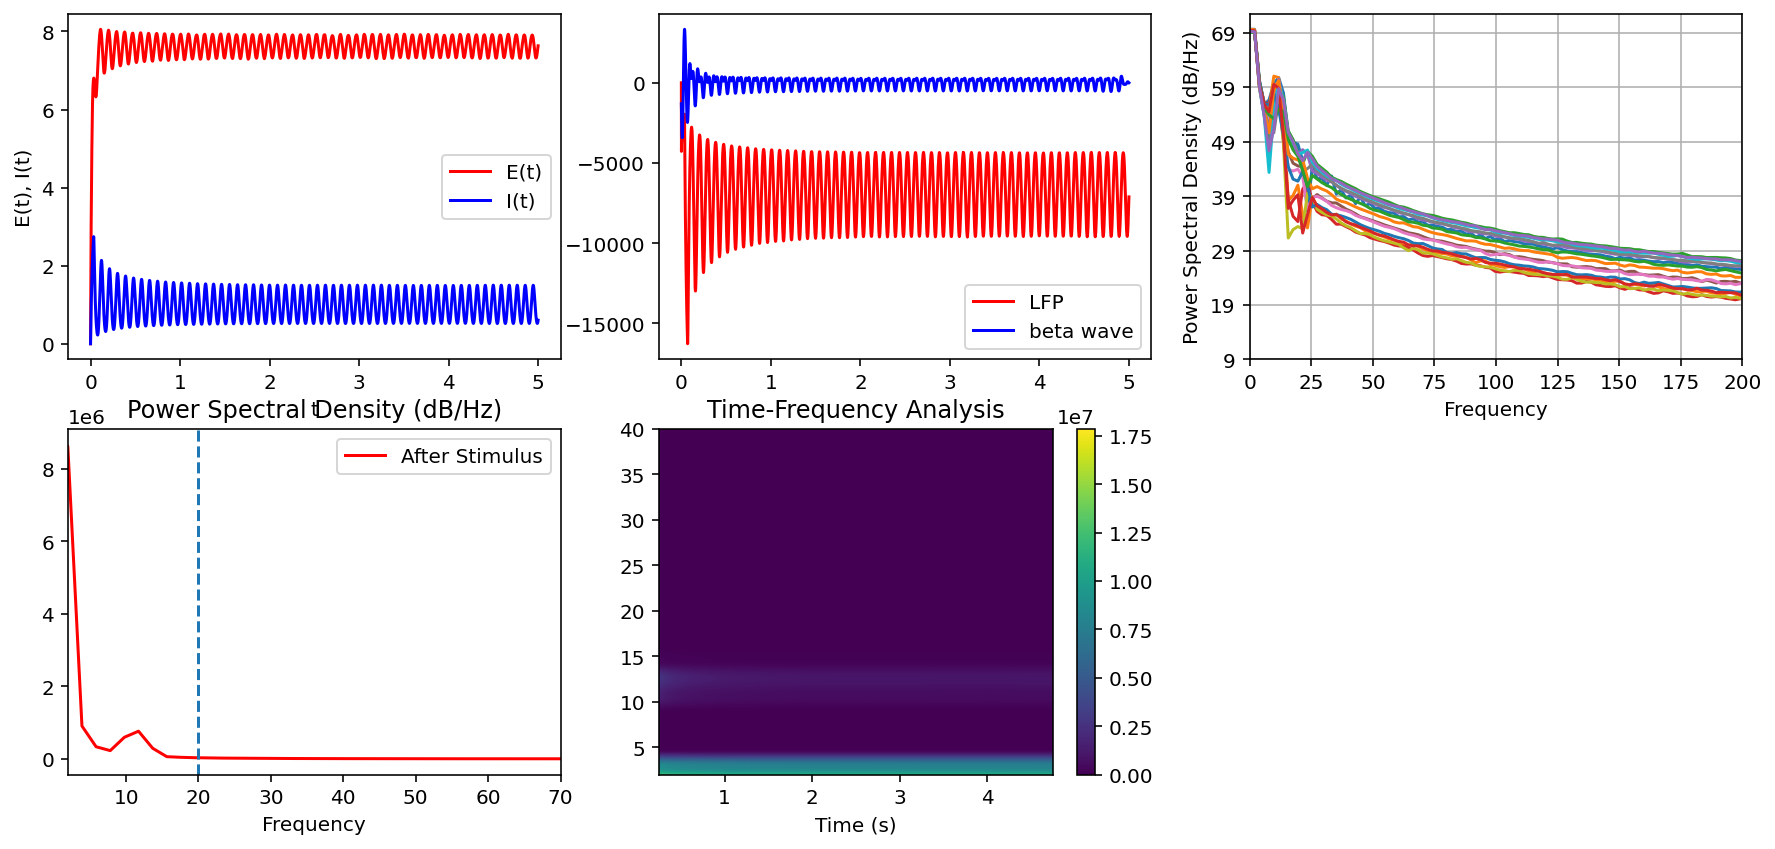

In [ ]:
# without delay, together with the following parameters, we can get the beta oscillation
# time stepsize for simulation

dt = 0.001

# simulation parameter, reference
# delay_EE=int(0./dt)   #unit ms
# delay_EI=int(0./dt) 
# delay_IE=int(0./dt)
# delay_II=int(0./dt)

# adjust phase lock
# delay_EE=int(0.03395/dt)   #unit ms
# delay_EI=int(0.005/dt)
# delay_IE=int(0.01/dt)       #useless for phase   
# delay_II=int(0.03/dt)

delay_EE=int(0.007/dt)
delay_EI=int(0.020/dt)#sensitive to E phase, right
delay_IE=int(0.007/dt)
delay_II=int(0.034/dt)#sensitive to I phase right, frequency increase 


# External input
wEE=0.40
wEI=0.592
# wEI=0
wIE=0.374
# wIE=0
wII=9.2   # frequency decrease
wES=0.63
# wES=0.683
wIS=1.493
# wES=0.5614
# wIS=1.227

# inhibition of SNc
S_spon=5.83
S_stim=3.658

#inhibition of SOM
# S_spon=7.51
# # S_stim=4.45
# S_stim=5

I_extE=-wES*S_stim
I_extI=-wIS*S_stim-2.0

# Excitatory parameters
# tau_E = 0.006      # Timescale of excitatory population
tau_E = 0.0078   # sensitive to the amplitude of the peak frequency
# a_E = 300       # Gain of excitatory population
# theta_E = 17   # Threshold of excitatory population

# Inhibitory parameters
# tau_I = 0.014     # Timescale of inhibitory population
# a_I = 400       # Gain of inhibitory population
# theta_I = 75     # Threshold of inhibitory population
r=0

a_E=16
theta_E=6
a_I=25
theta_I=5    #sensitive to the firing rate of I

tau0 = 0.002 # Noise time constant [sec]
sigma = 0.02 # Noise magnitude [nA]
I_noise= 1.5 # background current [nA]

# plot_phase()

tau_I = 0.01243


t = np.arange(0,5,dt)
E,I,LFP,beta_LFP = simulate_wc(t,0,0)
freqs0, pxx2_mean=frequency_analysis(t,E,I,LFP,beta_LFP)
# E0=np.linspace(0,1,200)
# I0=np.linspace(0,1,200)
E0=[0]
I0=[0]
t = np.arange(0,10,dt)
# plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2)
# phase=get_phase(beta_LFP-np.mean(beta_LFP),np.arange(200))
# print(phase.mean())
# print(phase[0:10])
# idx=np.abs(phase-np.pi/2)<(np.pi/4)
# plt.figure()
# plt.plot(t,beta_LFP)
# print(sum(idx))
# beta_LFP=(beta_LFP-np.mean(beta_LFP))/np.std(beta_LFP)




# HT_beta = hilbert(beta_LFP[2000:-1])  # compute hilbert transformation
# phases_beta = np.angle(HT_beta) # instantaneous phases at spike time of beta oscillations
# # print(phases_beta)

# plt.plot(beta_LFP[2000:-1])
# plt.title('$t_{onset}=2s$')
# fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,4))
# circular_hist(axs[0], phases_beta, offset = 0)
# # circular_hist(axs[1], phase, offset = 0)

In [ ]:
freqs_inhSOM=freqs0, 
pxx2_mean_inhSOM_inhiMSN=pxx2_mean

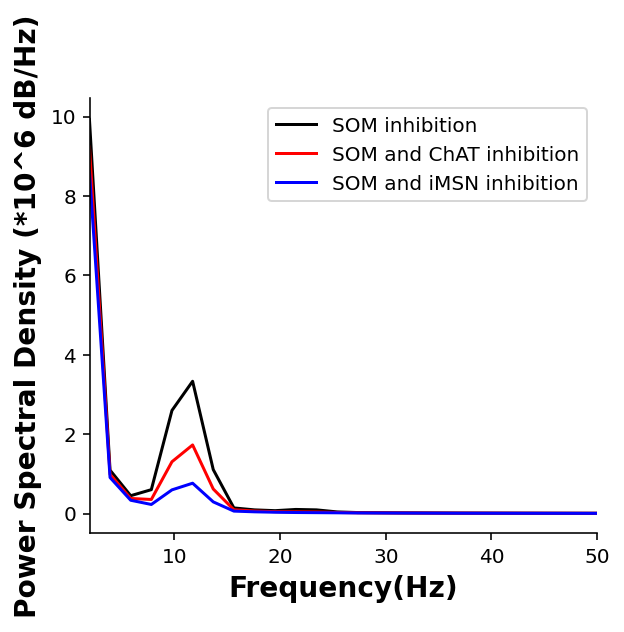

In [ ]:

fig = plt.figure(figsize=(10,4)) 
gs = gridspec.GridSpec(1, 2)
ax2=plt.subplot(gs[0]) 
ax2.plot(freqs0, pxx2_mean_inhSOM*1e-6,'k',label = 'SOM inhibition')
ax2.plot(freqs0, pxx2_mean_inhSOM_inhChAT*1e-6,'r',label = 'SOM and ChAT inhibition')
ax2.plot(freqs0, pxx2_mean_inhSOM_inhiMSN*1e-6,'b',label = 'SOM and iMSN inhibition')
ax2.set_xlabel('Frequency(Hz)',font1)
ax2.set_ylabel('Power Spectral Density (*10^6 dB/Hz)',font1)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,12,2))
ax2.set_xticklabels(np.arange(0,60,10))
# ax2.set_yticklabels(np.arange(0,8,2),font1)
ax2.set_xlim([2,50])
# ax2.set_ylim([0,6])
# ax2.set_title('without excitation from ChAT')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


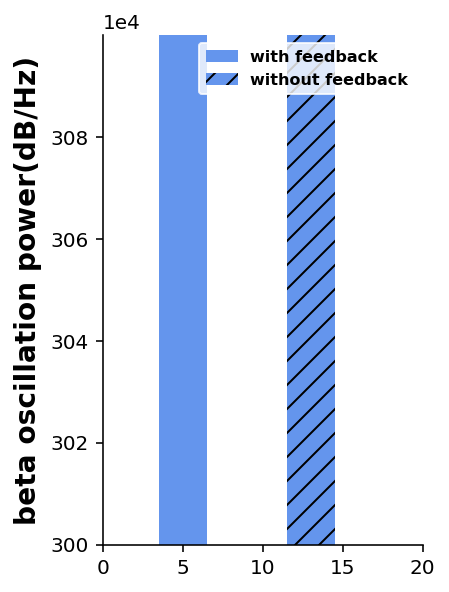

In [ ]:
font1={'family':'Times New Roman',
'weight':'bold',
'size': 14}
font2={'family':'Times New Roman',
'weight':'bold',
'size': 8}
beta_power=[3335877.141191949, 3331551.3913463247]
bar_width=3
fig, ax = plt.subplots(1,1,figsize=(3,4),constrained_layout=True)
ax.bar([5],beta_power[0], width=bar_width, color='cornflowerblue',label='with feedback')
ax.bar([10+bar_width],beta_power[1], width=bar_width, color='cornflowerblue',hatch='//',label='without feedback')

ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax.set_ylabel('beta oscillation power(dB/Hz)',font1)
ax.set_yticks(np.arange(3e6,3e6+1e5,2e4))
# ax.set_yticklabels(np.arange(3e6,3e6+1e5,2e4),font1)
ax.set_xlim([0,20])
ax.set_ylim([3e6,3e6+1e5])
ax.legend(loc='best',prop=font2,edgecolor='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('grid_figure.eps')




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


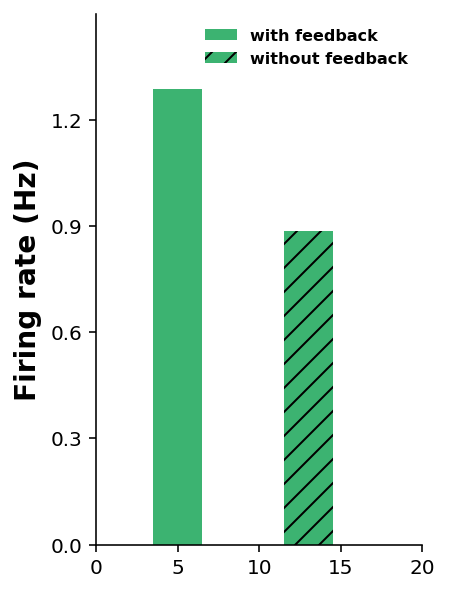

In [ ]:
font1={'family':'Times New Roman',
'weight':'bold',
'size': 14}
font2={'family':'Times New Roman',
'weight':'bold',
'size': 8}
iMSN_rate=[1.2881221677751116, 0.8863047319709633]
bar_width=3
fig, ax = plt.subplots(1,1,figsize=(3,4),constrained_layout=True)
ax.bar([5],iMSN_rate[0], width=bar_width, color='mediumseagreen',label='with feedback')
ax.bar([10+bar_width],iMSN_rate[1], width=bar_width, color='mediumseagreen',hatch='//',label='without feedback')

# ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
ax.set_ylabel('Firing rate (Hz)',font1)
ax.set_yticks(np.arange(0,1.5,0.3))
# ax.set_yticklabels(np.arange(3e6,3e6+1e5,2e4),font1)
ax.set_xlim([0,20])
ax.set_ylim([0,1.5])
ax.legend(loc='best',prop=font2,edgecolor='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('grid_figure.eps')


In [ ]:
tEE=0.007
tEI=0.020     # sensitive to E phase, right, phase difference
tIE=0.007
tII=0.034    #sensitive to I phase right, frequency increase, phase difference 

wEE=0.40   #phase difference
wEI=0.592
wIE=0.374
wII=9.2   # frequency decrease
wES=0.63
wIS=1.493

S_spon=5.83
S_stim=3.658
I1=-wES*S_stim
I2=-wIS*S_stim

w2=np.arccos(-1/wII)/tII
theta1=w2*tEI
theta2=w2*tEE
I0=0

tau_E = 0.0078   # sensitive to the amplitude of the peak frequency, phase difference
tau_I = 0.01243



a=w2*(tau_I*w2*wEI*wEE*(I0*(tau_I+tII)-I2*tII)*np.cos(theta1-theta2)
     +wEI*wEE*(I2*(tau_I+tII)+tau_I**2*I0*w2**2*tII)*np.sin(theta2-theta1)
     +I2*wEI*(tau_I*w2*tII+(tau_I+tII)*tau_E*w2)*np.cos(theta1)
     -tau_I*I0*w2*wEI*(tau_I+tII-tau_I*w2**2*tau_E*tII)*np.cos(theta1)
     +wEI*tau_I*I0*w2**2*(tau_I*tII+(tau_I+tII)*tau_E)*np.sin(theta1)
     +I2*wEI*(tau_I+tII-tau_I*w2**2*tau_E*tII)*np.sin(theta1)
)


b=w2*(tau_I*w2*wEI*wEE*(I0*(tau_I+tII)-I2*tII)*np.sin(theta2-theta1)
     -wEI*wEE*(I2*(tau_I+tII)+tau_I**2*I0*w2**2*tII)*np.cos(theta2-theta1)
     +I2*wEI*(-tau_I*w2**2*tII*tau_E+tau_I+tII)*np.cos(theta1)
     +tau_I*I0*w2**2*wEI*((tau_I+tII)*tau_E+tau_I*tII)*np.cos(theta1)
     +wEI*tau_I*I0*w2*(tau_I+tII-tau_I*w2**2*tau_E*tII)*np.sin(theta1)
     -I2*wEI*((tau_I+tII)*w2*tau_E+tau_I*w2*tII)*np.sin(theta1)
)

m=-I2*tII*w2**2*tau_I+tau_I*I0*w2**2*(tau_I+tII)

n=-tau_I**2*I0*w2**3*tII-I2*w2*(tau_I+tII)

tan_diff=(tau_E*w2*np.cos(tEI*w2) + wEE*np.sin(w2*(tEE - tEI)) + np.sin(tEI*w2))/(tau_E*w2*np.sin(tEI*w2) + wEE*np.cos(w2*(tEE - tEI)) - np.cos(tEI*w2))

a1=-a/b
a2=-m/n
diff=(a1-a2)/(1+a1*a2)
print(diff)
print(np.arctan(diff)/(2*np.pi)*360)
print(np.arctan(tan_diff)/(2*np.pi)*360)
print(np.arctan(a1)/(2*np.pi)*360)
print(np.arctan(a2)/(2*np.pi)*360)
print(np.arccos(-1/9.2)/tII)
print(w2/(2*np.pi))
# print(np.cos(theta1-theta2))
# print(np.sin(theta1-theta2))
# print(np.cos(theta1))
# print(np.sin(theta1))
# tEE=0.006
# tEI=0.035     # sensitive to E phase, right
# tIE=0.001
# tII=0.01723    #sensitive to I phase, right   


# wEE=0.5
# wEI=0.592
# wIE=0.
# wII=18.876063
# w2=16*2*np.pi
# theta1=w2*tEI
# theta2=w2*tEE
# I0=0
# tau_E = 0.004   
# tau_I = 0.011
# I1 = 2
# I2 = 1.15

8.801028123987674
83.51767720424161
83.51767720424162
59.30506010839102
-24.212617095850607
49.40315177104659
7.862755808681189


[11.71875]
3365086.9150420744


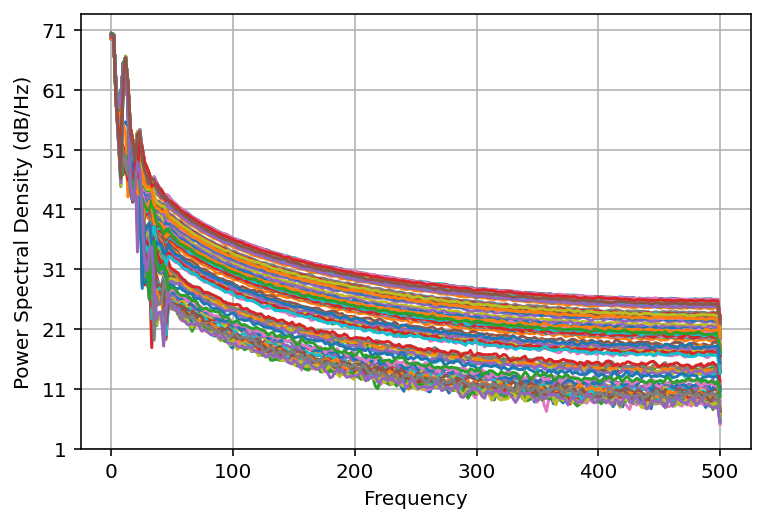

In [ ]:
t = np.arange(0,25,dt)
t1 = np.arange(0,10,dt)
I_extE=-wES*S_spon
I_extI=-wIS*S_spon
E_spon,I_spon,LFP_spon,beta_LFP, = simulate_wc(t,0,0)
pxx2_mean_spon,freqs_spon=power_analysis(LFP_spon,dt)
I_extE=-wES*S_stim
I_extI=-wIS*S_stim
E_stim,I_stim,LFP_stim,beta_LFP = simulate_wc(t,0,0)
pxx2_mean_stim,freqs_stim=power_analysis(LFP_stim,dt)
E_spon=E_spon[0:len(t1)]
I_spon=I_spon[0:len(t1)]
E_stim=E_stim[0:len(t1)]
I_stim=I_stim[0:len(t1)]
LFP_tol=np.hstack((LFP_spon,LFP_stim))
fre,pmax=max_power(freqs_stim,pxx2_mean_stim)
print(fre)
print(pmax)
# dl=320
# pxx2, freqs = plt.psd(LFP_stim[:dl],  NFFT = 512,  Fs = 1./dt, scale_by_freq = True, noverlap = 250)
# bins = int(len(LFP_stim) / dl)
# for b in range(1, bins):
#     start = dl * b
#     end = dl * (b + 1)
#     mid_pxx, mid_freq = plt.psd(LFP_stim[start:end],  NFFT = 512, Fs = 1./dt, scale_by_freq = True, noverlap = 250)
#     pxx2 = np.vstack((pxx2, mid_pxx))
# pxx2_mean = pxx2.mean(0)

/tmp/ipykernel_50090/913040783.py:9: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax2.set_xticklabels(np.arange(0,60,10),font1)
/tmp/ipykernel_50090/913040783.py:10: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax2.set_yticklabels(np.arange(10,60,10),font1)


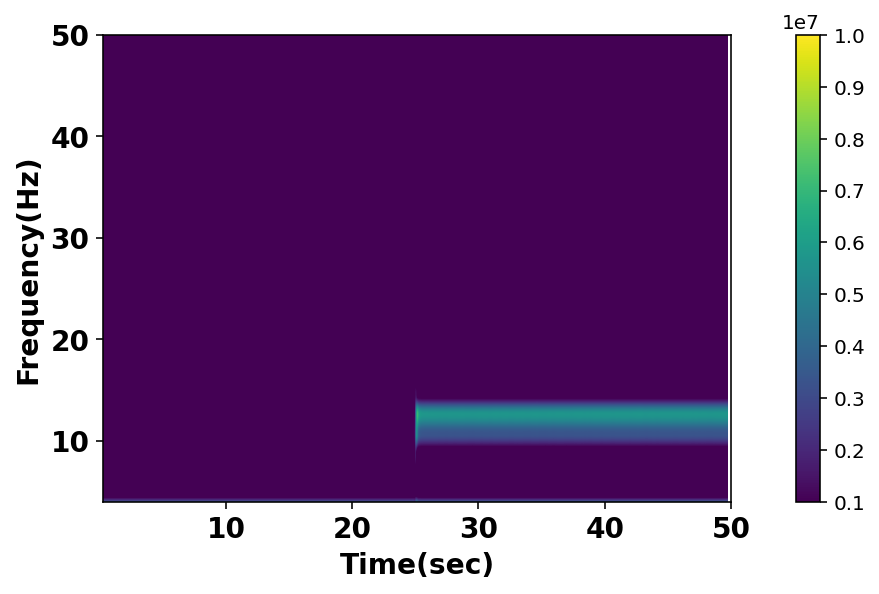

In [ ]:
fig, ax2 = plt.subplots(1,1,constrained_layout=True)
psm = ax2.specgram(LFP_tol, NFFT = 512,Fs = 1./dt, scale = 'linear' ,
                                      scale_by_freq = True, noverlap = 500,vmin=1e6,vmax=10e6)
fig.colorbar(psm[3], ax=ax2,aspect=20)
ax2.set_xlabel('Time(sec)',font1)
ax2.set_ylabel('Frequency(Hz)',font1)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(10,60,10))
ax2.set_xticklabels(np.arange(0,60,10),font1)
ax2.set_yticklabels(np.arange(10,60,10),font1)
ax2.set_xlim([0.3,50])
ax2.set_ylim([4,50])
plt.savefig('power1.eps')

/tmp/ipykernel_50090/433803366.py:23: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax0.set_xticklabels(np.arange(0,5,0.5),font1)
/tmp/ipykernel_50090/433803366.py:24: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax0.set_yticklabels(np.arange(0,12,2),font1)
/tmp/ipykernel_50090/433803366.py:40: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax1.set_xticklabels(np.arange(0,5,0.5),font1)
/tmp/ipykernel_50090/433803366.py:41: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Ma

[5.61765530713777, 0.8148355102008618]
[7.313698708046047, 1.288070122982929]


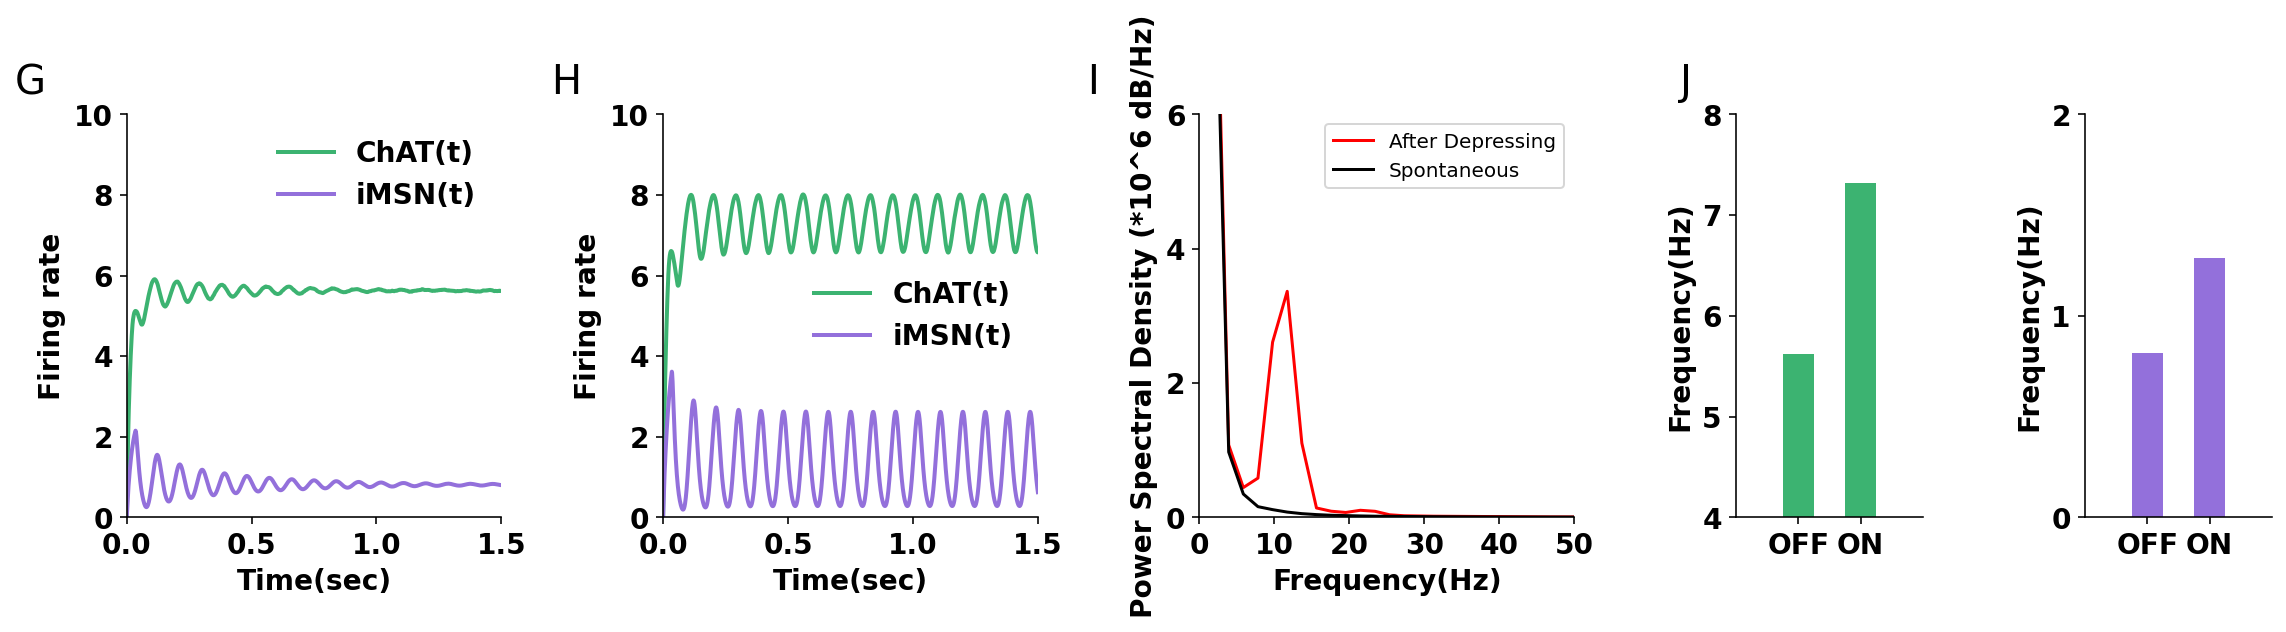

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec
font1={'family':'Times New Roman',
'weight':'bold',
'size': 14}
x=np.arange(0,1.5,0.5)
fig = plt.figure(figsize=(16,4)) 
gs = gridspec.GridSpec(1, 5, width_ratios=[2,2,2,1,1])
ax0=plt.subplot(gs[0]) 
letter='G'
ax0.text(-0.30,1.05,'%s'%letter,fontsize=20,weight='normal', transform=ax0.transAxes)
# fig, ax = plt.subplots(1,4, figsize=(17,3),constrained_layout=True, width_ratios=[2,2,2, 1])
# for axi, letter in zip(ax.flatten(), 'GHIJ'):
#     axi.text(-0.30,1.05,'%s'%letter,fontsize=20,weight='normal', transform=axi.transAxes)

ax0.plot(t1,E_spon,color='mediumseagreen',linewidth=2,label='ChAT')
ax0.plot(t1,I_spon,color='mediumpurple',linewidth=2,label='iMSN')
ax0.set_xlabel('Time(sec)',font1)
ax0.set_ylabel('Firing rate',font1)
ax0.set_xticks(np.arange(0,5,0.5))
ax0.set_yticks(np.arange(0,12,2))
ax0.set_xticklabels(np.arange(0,5,0.5),font1)
ax0.set_yticklabels(np.arange(0,12,2),font1)
ax0.set_xlim([0,1.5])
ax0.set_ylim([0,10])
ax0.legend(['ChAT(t)','iMSN(t)'],loc='best',prop=font1,edgecolor='white')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1=plt.subplot(gs[1]) 
letter='H'
ax1.text(-0.30,1.05,'%s'%letter,fontsize=20,weight='normal', transform=ax1.transAxes)
ax1.plot(t1,E_stim,color='mediumseagreen',linewidth=2,label='ChAT')
ax1.plot(t1,I_stim,color='mediumpurple',linewidth=2,label='iMSN')
ax1.set_xlabel('Time(sec)',font1)
ax1.set_ylabel('Firing rate',font1)
ax1.set_xticks(np.arange(0,5,0.5))
ax1.set_yticks(np.arange(0,12,2))
ax1.set_xticklabels(np.arange(0,5,0.5),font1)
ax1.set_yticklabels(np.arange(0,12,2),font1)
ax1.set_xlim([0,1.5])
ax1.set_ylim([0,10])
ax1.legend(['ChAT(t)','iMSN(t)'],loc='best',prop=font1,edgecolor='white')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


ax2=plt.subplot(gs[2]) 
letter='I'
ax2.text(-0.30,1.05,'%s'%letter,fontsize=20,weight='normal', transform=ax2.transAxes)
ax2.plot(freqs_stim, pxx2_mean_stim*1e-6,'r',label = 'After Depressing')
ax2.plot(freqs_spon, pxx2_mean_spon*1e-6, 'k', label = 'Spontaneous')
ax2.set_xlabel('Frequency(Hz)',font1)
ax2.set_ylabel('Power Spectral Density (*10^6 dB/Hz)',font1)
ax2.set_xticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,8,2))
ax2.set_xticklabels(np.arange(0,60,10),font1)
ax2.set_yticklabels(np.arange(0,8,2),font1)
ax2.set_xlim([0,50])
ax2.set_ylim([0,6])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
# plt.ylim(ymin = 0.0 * 1e-6,ymax=0.5*1e-5)
# psm = ax2.specgram(LFP_tol, NFFT = 512,Fs = 1./dt, scale = 'linear' ,
#                                       scale_by_freq = True, noverlap = 500,vmin=2e6,vmax=6e6)
# fig.colorbar(psm[3], ax=ax2,aspect=20)
# ax2.set_xlabel('Time(sec)',font1)
# ax2.set_ylabel('Frequency(Hz)',font1)
# ax2.set_xticks(np.arange(2,12,2))
# ax2.set_yticks(np.arange(10,60,10))
# ax2.set_xticklabels(np.arange(2,12,2),font1)
# ax2.set_yticklabels(np.arange(10,60,10),font1)
# ax2.set_xlim([0.3,9.7])
# ax2.set_ylim([4,50])
# ax[2].spines['right'].set_visible(False)
# ax[2].spines['top'].set_visible(False)


spon=[np.mean(E_spon),np.mean(I_spon)]
stim=[np.mean(E_stim),np.mean(I_stim)] 
# inhibition of SNc
# spon_ref = np.array([7.94,0.84])
# stim_ref = np.array([10.97, 1.44])
#inhibition of SOM
spon_ref = np.array([5.63,0.23])
stim_ref = np.array([ 8.83, 0.43 ])
state=['OFF','ON']
bar_width=0.5

# index_sponsimu=np.arange(len(neuron))
# index_sponref=index_sponsimu+bar_width
# index_suppsimu=index_sponsimu+2*bar_width
# index_suppref=index_sponsimu+3*bar_width

ax3=plt.subplot(gs[3]) 
letter='J'
ax3.text(-0.30,1.05,'%s'%letter,fontsize=20,weight='normal', transform=ax3.transAxes)
ax3.bar([1],spon[0], width=bar_width, color='mediumseagreen',label='OFF')
# ax[3].bar([0.5+bar_width*1.5],spon_ref[0], width=bar_width, color='mediumseagreen',hatch='//',edgecolor='black')
ax3.bar([2],stim[0], width=bar_width, color='mediumseagreen',label='ON')
# ax[3].bar([0.5+bar_width*4.5],stim_ref[0], width=bar_width, color='mediumseagreen',edgecolor='black')
ax3.set_ylabel('Frequency(Hz)',font1)
ax3.set_xticks([1,2])
ax3.set_yticks(np.arange(0,12,1))
ax3.set_xticklabels(state,font1)
ax3.set_yticklabels(np.arange(0,12,1),font1)
ax3.set_xlim([0,3])
ax3.set_ylim([4,8])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4=plt.subplot(gs[4]) 
# letter='A'
# ax4.text(-0.30,1.05,'%s'%letter,fontsize=20,weight='normal', transform=ax4.transAxes)
ax4.bar([1],spon[1], width=bar_width, color='mediumpurple',label='OFF')
# ax[3].bar([2.5+bar_width*1.5],spon_ref[1], width=bar_width, color='mediumpurple',hatch='//',edgecolor='black')
ax4.bar([2],stim[1], width=bar_width, color='mediumpurple',label='ON')
# ax[3].bar([2.5+bar_width*4.5],stim_ref[1], width=bar_width, color='mediumpurple',edgecolor='black')
ax4.set_ylabel('Frequency(Hz)',font1)
ax4.set_xticks([1,2])
ax4.set_yticks(np.arange(0,12,1))
ax4.set_xticklabels(state,font1)
ax4.set_yticklabels(np.arange(0,12,1),font1)
ax4.set_xlim([0,3])
ax4.set_ylim([0,2])
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('grid_figure.eps')
print(spon)
print(stim)



2382977.7077770797
[60.546875]


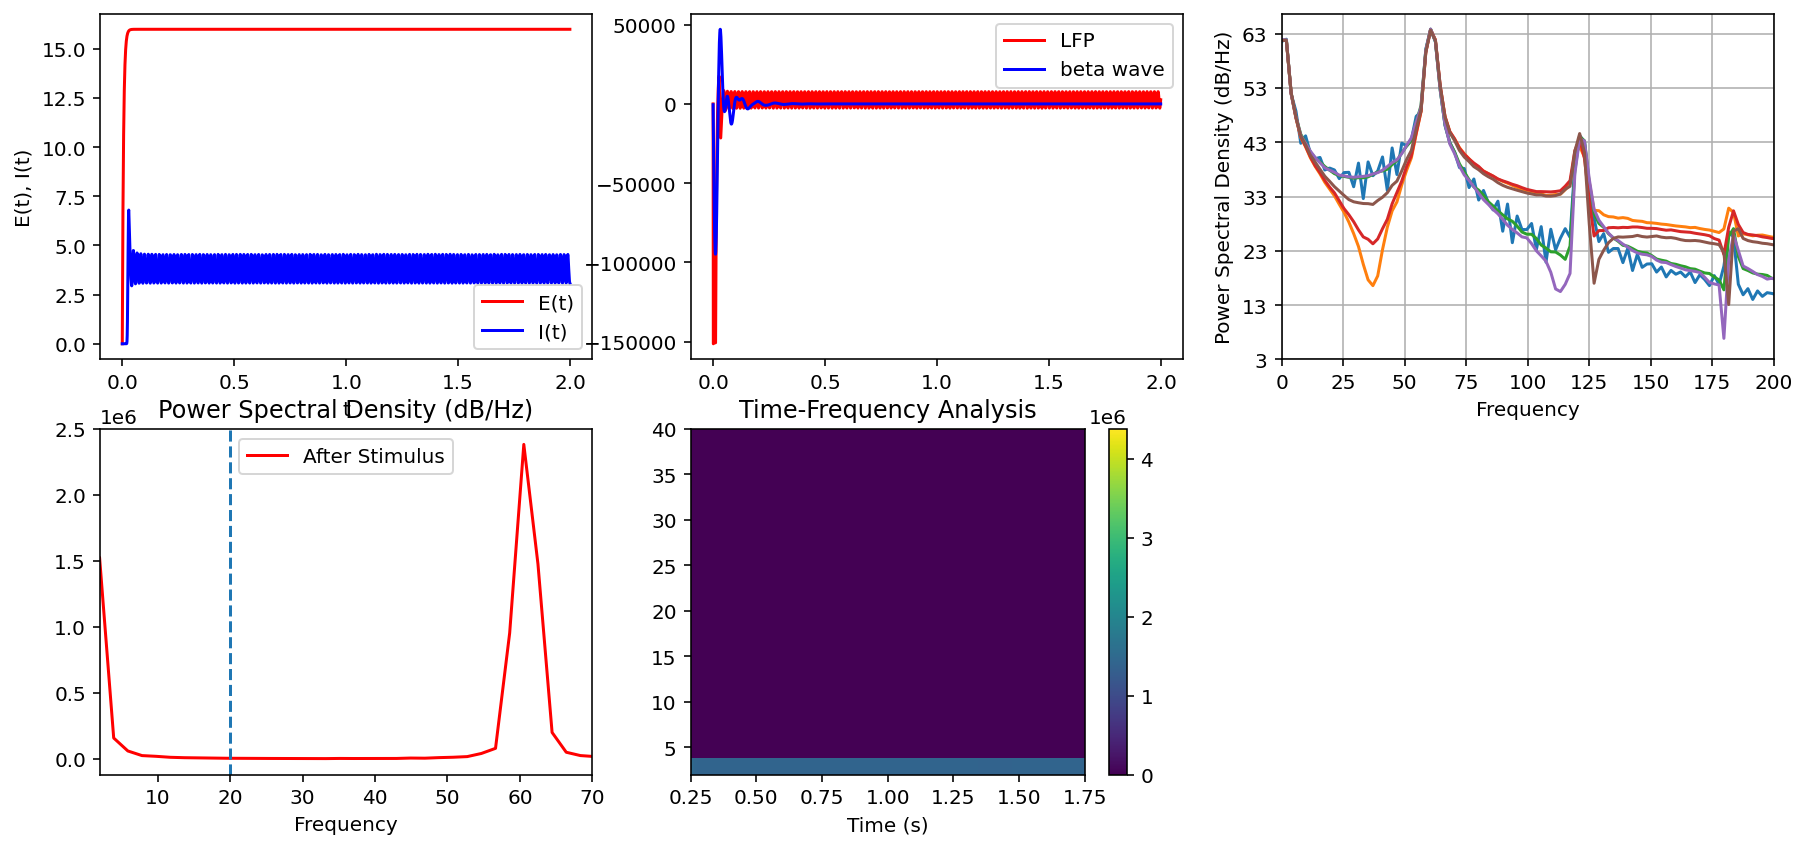

In [ ]:
# without delay, together with the following parameters, we can get the beta oscillation
# time stepsize for simulation

dt = 0.001

# adjust phase lock
# delay_EE=int(0.03395/dt)   #unit ms
# delay_EI=int(0.005/dt)
# delay_IE=int(0.01/dt)       #useless for phase   
# delay_II=int(0.03/dt)

delay_EE=int(0.01/dt)
delay_EI=int(0.006/dt)  # sensitive to E phase, right
delay_IE=int(0.01/dt)
delay_II=int(0.004/dt)  #sensitive to I phase right, frequency increase 


# External input


# I_extE = -5
# I_extI = -9
I_extE=27*9.2
I_extI=-2*139.4
wEE=0
wEI=10.7
wIE=20
wII=12.3    #frequency decrease


# Excitatory parameters
# tau_E = 0.006      # Timescale of excitatory population
tau_E = 0.006   # sensitive to the amplitude of the peak frequency
# a_E = 300       # Gain of excitatory population
# theta_E = 17   # Threshold of excitatory population

# Inhibitory parameters
# tau_I = 0.014     # Timescale of inhibitory population
# a_I = 400       # Gain of inhibitory population
# theta_I = 75     # Threshold of inhibitory population
r=0

a_E=16
theta_E=6
a_I=25
theta_I=5    #sensitive to the firing rate of I

tau0 = 0.002 # Noise time constant [sec]
sigma = 0.02 # Noise magnitude [nA]
I_noise= 1 # background current [nA]

# plot_phase()

tau_I = 0.014


t = np.arange(0,2,dt)
E,I,LFP,beta_LFP = simulate_wc(t,0,0)
frequency_analysis(t,E,I,LFP,beta_LFP)
# E0=np.linspace(0,1,200)
# I0=np.linspace(0,1,200)
E0=[0]
I0=[0]
t = np.arange(0,2,dt)
# plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2)
# phase=get_phase(beta_LFP-np.mean(beta_LFP),np.arange(200))
# print(phase.mean())
# print(phase[0:10])
# idx=np.abs(phase-np.pi/2)<(np.pi/4)
# plt.figure()
# plt.plot(t,beta_LFP)
# print(sum(idx))
# beta_LFP=(beta_LFP-np.mean(beta_LFP))/np.std(beta_LFP)




# HT_beta = hilbert(beta_LFP[2000:-1])  # compute hilbert transformation
# phases_beta = np.angle(HT_beta) # instantaneous phases at spike time of beta oscillations
# # print(phases_beta)

# plt.plot(beta_LFP[2000:-1])
# plt.title('$t_{onset}=2s$')
# fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,4))
# circular_hist(axs[0], phases_beta, offset = 0)
# # circular_hist(axs[1], phase, offset = 0)

-50.254343573310315


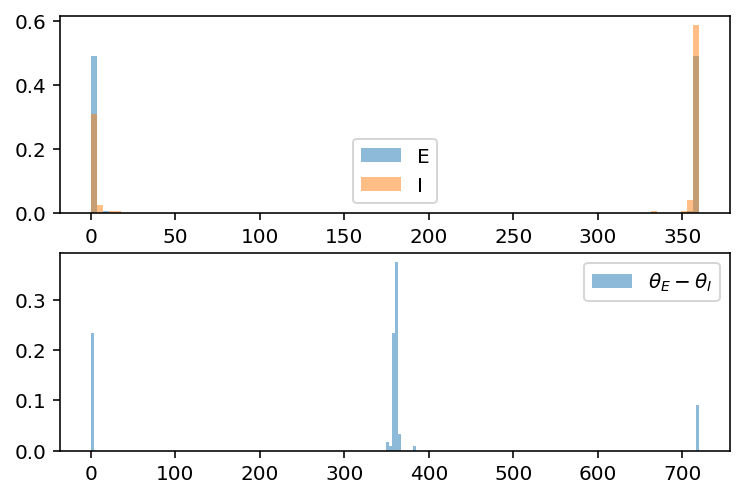

In [ ]:
# the phase of E, I population activity and its difference 
E,I,LFP,beta_LFP = simulate_wc(t,-1,-1)
import pandas as pd
# E=(E-np.mean(E))/np.std(E)
# I=(I-np.mean(I))/np.std(I)
pointE,valueE = local_maximum_point(E)
pointI,valueI = local_maximum_point(I)
# phases_E=get_phase(E,np.arange(len(E)))
# phases_I=get_phase(I,np.arange(len(E)))
phases_E=get_phase(E,pointI)
phases_I=get_phase(I,pointI)
phases_E=(phases_E/(2*np.pi))*360
phases_I=(phases_I/(2*np.pi))*360
anglediff = phases_E-phases_I
countsE, binsE=np.histogram(phases_E,bins=100)
countsI, binsI=np.histogram(phases_I,bins=binsE)
binto=np.hstack((-binsE[np.arange(len(binsE)-1,0,-1)],binsE))
# hilE=hilbert(E)
# hilI=hilbert(I)
# anglediff=(np.angle(hilE)-np.angle(hilI))/(2*np.pi)*360
# angE=(np.angle(hilE)/(2*np.pi))*360
# angI=(np.angle(hilI)/(2*np.pi))*360
# print(anglediff)
# countsE, binsE=np.histogram(angE)
# countsI, binsI=np.histogram(angI)
plt.subplot(2,1,1)
plt.hist(binsE[:-1],binsE,weights=countsE/np.sum(countsE),alpha=0.5, label='E')
plt.hist(binsI[:-1],binsI,weights=countsI/np.sum(countsI),alpha=0.5, label='I')
plt.legend()
plt.subplot(2,1,2)
counts, bins=np.histogram(anglediff,bins=binto)
plt.hist(bins[:-1]+360,bins+360,weights=counts/np.sum(counts),alpha=0.5,label=r'$\theta_E-\theta_I$')
# plt.xlim([0,360])
plt.legend()
print(np.mean(anglediff))

In [ ]:
index1=np.argwhere(w2>12.5)
row_index1=np.zeros(len(index1))
for i in range(len(index1)):
    row_index1[i]=index1[i][0]
index_max=max(row_index1)
tii_max=tII_tol[int(index_max)]

index2=np.argwhere(w2<25.0)
row_index2=np.zeros(len(index2))
for i in range(len(index2)):
    row_index2[i]=index2[i][0]
index_min=min(row_index2)
tii_min=tII_tol[int(index_min)]
print(tii_min)
print(tii_max)



0.011
0.026


In [ ]:
tEE=0.006
tEI=0.022     # sensitive to E phase, right
tIE=0.006
tII=0.033    #sensitive to I phase right, frequency increase 

wEE=0.5
wEI=0.592
wIE=0.374
wII=9.2   # frequency decrease
wES=0.683
wIS=1.493

S_spon=5.83
S_stim=3.658
I1=-wES*S_stim
I2=-wIS*S_stim

w2=np.arccos(-1/wII)/tII
theta1=w2*tEI
theta2=w2*tEE
I0=0

tau_E = 0.0065   # sensitive to the amplitude of the peak frequency
tau_I = 0.01243



a=w2*(tau_I*w2*wEI*wEE*(I0*(tau_I+tII)-I2*tII)*np.cos(theta1-theta2)
     +wEI*wEE*(I2*(tau_I+tII)+tau_I**2*I0*w2**2*tII)*np.sin(theta2-theta1)
     +I2*wEI*(tau_I*w2*tII+(tau_I+tII)*tau_E*w2)*np.cos(theta1)
     -tau_I*I0*w2*wEI*(tau_I+tII-tau_I*w2**2*tau_E*tII)*np.cos(theta1)
     +wEI*tau_I*I0*w2**2*(tau_I*tII+(tau_I+tII)*tau_E)*np.sin(theta1)
     +I2*wEI*(tau_I+tII-tau_I*w2**2*tau_E*tII)*np.sin(theta1)
)


b=w2*(tau_I*w2*wEI*wEE*(I0*(tau_I+tII)-I2*tII)*np.sin(theta2-theta1)
     -wEI*wEE*(I2*(tau_I+tII)+tau_I**2*I0*w2**2*tII)*np.cos(theta2-theta1)
     +I2*wEI*(-tau_I*w2**2*tII*tau_E+tau_I+tII)*np.cos(theta1)
     +tau_I*I0*w2**2*wEI*((tau_I+tII)*tau_E+tau_I*tII)*np.cos(theta1)
     +wEI*tau_I*I0*w2*(tau_I+tII-tau_I*w2**2*tau_E*tII)*np.sin(theta1)
     -I2*wEI*((tau_I+tII)*w2*tau_E+tau_I*w2*tII)*np.sin(theta1)
)

m=-I2*tII*w2**2*tau_I+tau_I*I0*w2**2*(tau_I+tII)

n=-tau_I**2*I0*w2**3*tII-I2*w2*(tau_I+tII)

tan_diff=(tau_E*w2*np.cos(tEI*w2) + wEE*np.sin(w2*(tEE - tEI)) + np.sin(tEI*w2))/(tau_E*w2*np.sin(tEI*w2) + wEE*np.cos(w2*(tEE - tEI)) - np.cos(tEI*w2))

a1=-a/b
a2=-m/n
diff=(a1-a2)/(1+a1*a2)
print(diff)
print(np.arctan(diff)/(2*np.pi)*360)
print(np.arctan(tan_diff)/(2*np.pi)*360)
print(np.arctan(a1)/(2*np.pi)*360)
print(np.arctan(a2)/(2*np.pi)*360)
print(np.arccos(-1/9.2)/tII)
print(w2/(2*np.pi))
# print(np.cos(theta1-theta2))
# print(np.sin(theta1-theta2))
# print(np.cos(theta1))
# print(np.sin(theta1))
# tEE=0.006
# tEI=0.035     # sensitive to E phase, right
# tIE=0.001
# tII=0.01723    #sensitive to I phase, right   


# wEE=0.5
# wEI=0.592
# wIE=0.
# wII=18.876063
# w2=16*2*np.pi
# theta1=w2*tEI
# theta2=w2*tEE
# I0=0
# tau_E = 0.004   
# tau_I = 0.011
# I1 = 2
# I2 = 1.15

3.3187698530849676
73.2315809705622
73.2315809705622
48.548973160975684
-24.682607809586507
50.90021697622982
8.101021136216982


In [ ]:
from sympy import *
tEE, tEI, tIE, tII, wEE, wEI, wIE, wII, w2, I0, tau_E, tau_I, I1, I2= symbols('tEE, tEI, tIE, tII, wEE, wEI, wIE, wII, w2, I0, tau_E, tau_I, I1, I2')
theta1=w2*tEI
theta2=w2*tEE
a=w2*(tau_I*w2*wEI*wEE*(I0*(tau_I+tII)-I2*tII)*cos(theta1-theta2)
     +wEI*wEE*(I2*(tau_I+tII)+tau_I**2*I0*w2**2*tII)*sin(theta2-theta1)
     +I2*wEI*(tau_I*w2*tII+(tau_I+tII)*tau_E*w2)*cos(theta1)
     -tau_I*I0*w2*wEI*(tau_I+tII-tau_I*w2**2*tau_E*tII)*cos(theta1)
     +wEI*tau_I*I0*w2**2*(tau_I*tII+(tau_I+tII)*tau_E)*sin(theta1)
     +I2*wEI*(tau_I+tII-tau_I*w2**2*tau_E*tII)*sin(theta1)
)


b=w2*(tau_I*w2*wEI*wEE*(I0*(tau_I+tII)-I2*tII)*sin(theta2-theta1)
     -wEI*wEE*(I2*(tau_I+tII)+tau_I**2*I0*w2**2*tII)*cos(theta2-theta1)
     +I2*wEI*(-tau_I*w2**2*tII*tau_E+tau_I+tII)*cos(theta1)
     +tau_I*I0*w2**2*wEI*((tau_I+tII)*tau_E+tau_I*tII)*cos(theta1)
     +wEI*tau_I*I0*w2*(tau_I+tII-tau_I*w2**2*tau_E*tII)*sin(theta1)
     -I2*wEI*((tau_I+tII)*w2*tau_E+tau_I*w2*tII)*sin(theta1)
)
m=-I2*tII*w2**2*tau_I+tau_I*I0*w2**2*(tau_I+tII)

n=-tau_I**2*I0*w2**3*tII-I2*w2*(tau_I+tII)
a1=-a/b
a2=-m/n
diff=(a1-a2)/(1+a1*a2)
s_expr=simplify(diff)
print(simplify(a1))
print(simplify(a2))
print(s_expr)


(-I0*tau_I*w2**2*(tII*tau_I + tau_E*(tII + tau_I))*sin(tEI*w2) + I0*tau_I*w2*(-tII*tau_E*tau_I*w2**2 + tII + tau_I)*cos(tEI*w2) - I2*w2*(tII*tau_I + tau_E*(tII + tau_I))*cos(tEI*w2) - I2*(-tII*tau_E*tau_I*w2**2 + tII + tau_I)*sin(tEI*w2) - tau_I*w2*wEE*(I0*(tII + tau_I) - I2*tII)*cos(w2*(tEE - tEI)) - wEE*(I0*tII*tau_I**2*w2**2 + I2*(tII + tau_I))*sin(w2*(tEE - tEI)))/(I0*tau_I*w2**2*(tII*tau_I + tau_E*(tII + tau_I))*cos(tEI*w2) + I0*tau_I*w2*(-tII*tau_E*tau_I*w2**2 + tII + tau_I)*sin(tEI*w2) - I2*w2*(tII*tau_I + tau_E*(tII + tau_I))*sin(tEI*w2) + I2*(-tII*tau_E*tau_I*w2**2 + tII + tau_I)*cos(tEI*w2) + tau_I*w2*wEE*(I0*(tII + tau_I) - I2*tII)*sin(w2*(tEE - tEI)) - wEE*(I0*tII*tau_I**2*w2**2 + I2*(tII + tau_I))*cos(w2*(tEE - tEI)))
tau_I*w2*(I0*(tII + tau_I) - I2*tII)/(I0*tII*tau_I**2*w2**2 + I2*(tII + tau_I))
(tau_E*w2*cos(tEI*w2) + wEE*sin(w2*(tEE - tEI)) + sin(tEI*w2))/(tau_E*w2*sin(tEI*w2) + wEE*cos(w2*(tEE - tEI)) - cos(tEI*w2))


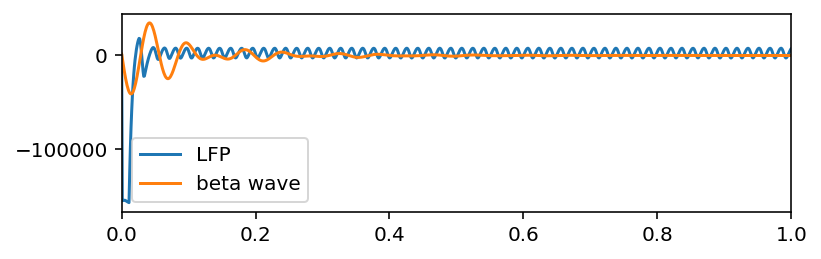

In [ ]:

upfilter = 36
# calculate the beta wave 12.5-30
b,a = signal.cheby2(N = 4, rs = upfilter, Wn = [12, 25.], btype = 'bandpass',fs=1000)
# b,a = signal.butter(N = 5, Wn = [12.5, 30.], btype = 'bandpass',fs=1000)

  # use band pass chebyshev-2 
beta_LFP = signal.filtfilt(b,a, LFP) # filter out beta band oscillations
plt.subplot(2,1,2)
plt.plot(t,LFP,label='LFP')
plt.xlim([0,1])
plt.subplot(2,1,2)
plt.plot(t,beta_LFP,label='beta wave')
plt.xlim([0,1])
plt.legend()


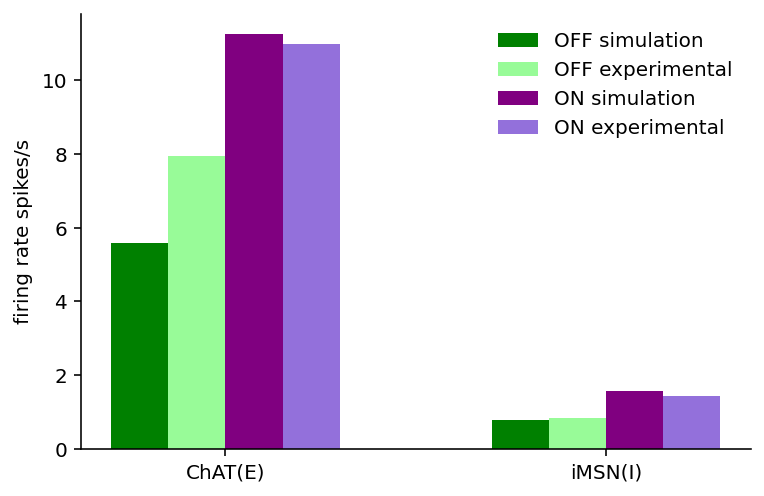

In [ ]:
spon=[5.57,0.78]
stim=[11.24,1.56]
spon_ref = np.array([7.94,0.84])
stim_ref = np.array([10.97, 1.44])
neuron=['ChAT(E)','iMSN(I)']
bar_width=0.15
index_sponsimu=np.arange(len(neuron))
index_sponref=index_sponsimu+bar_width
index_suppsimu=index_sponsimu+2*bar_width
index_suppref=index_sponsimu+3*bar_width


plt.bar(index_sponsimu,spon,width=bar_width,color='green',label='OFF simulation')
plt.bar(index_sponref,spon_ref,width=bar_width,color='palegreen',label='OFF experimental')
plt.bar(index_suppsimu,stim,width=bar_width,color='purple',label='ON simulation')
plt.bar(index_suppref,stim_ref,width=bar_width,color='mediumpurple',label='ON experimental')
plt.legend(frameon=False)
plt.xticks(index_sponref+bar_width/2,neuron)
plt.ylabel('firing rate spikes/s')
# plt.title('spontaneous state')
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



Text(0.5, 1.0, 'ON')

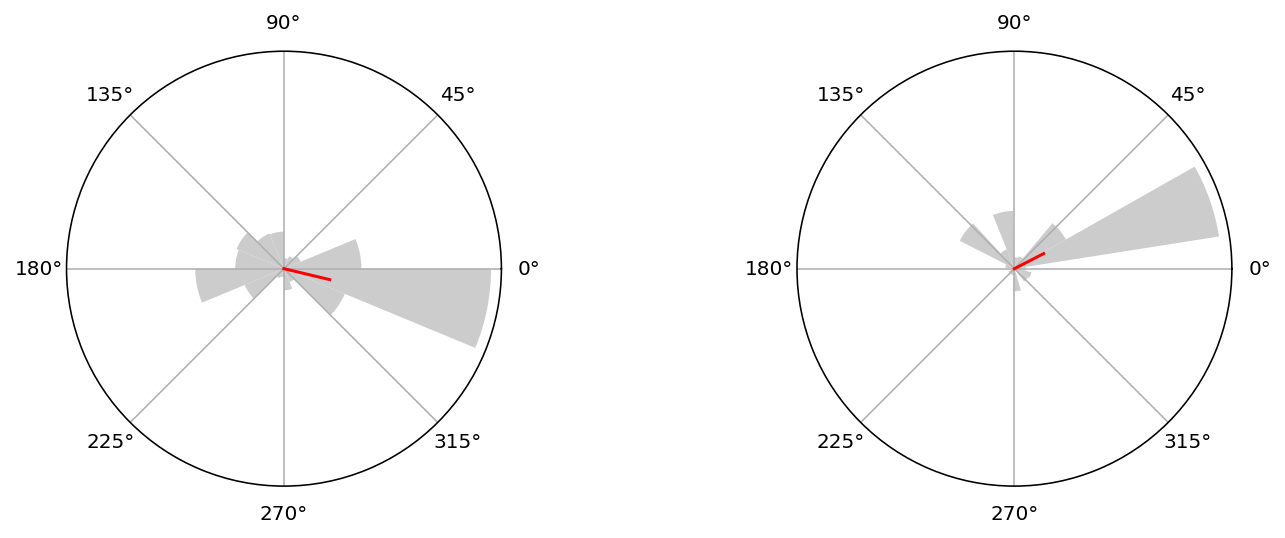

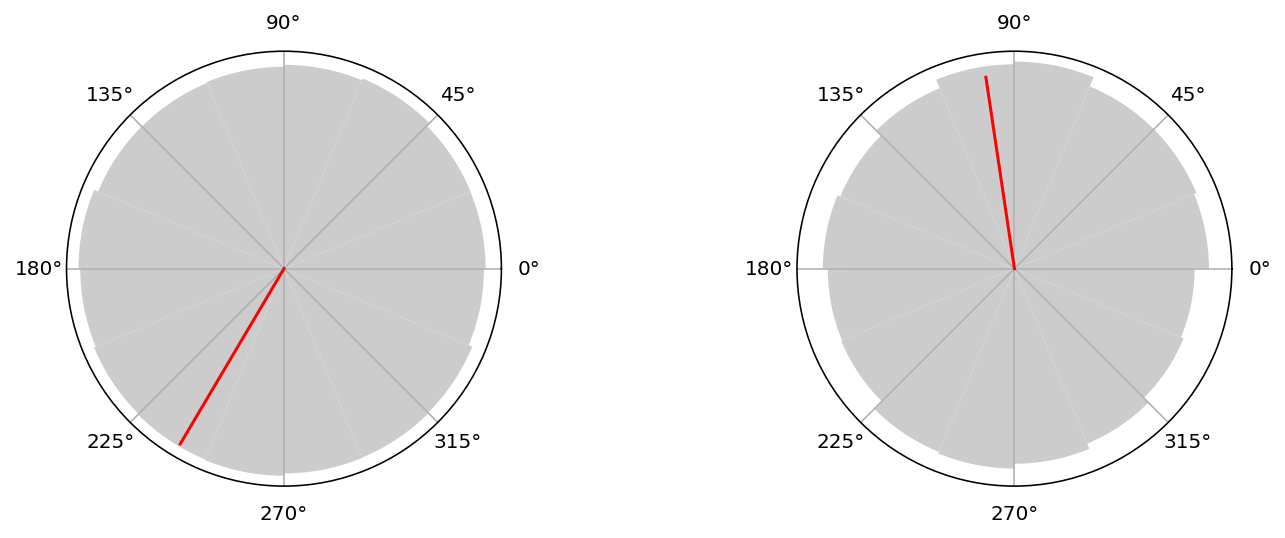

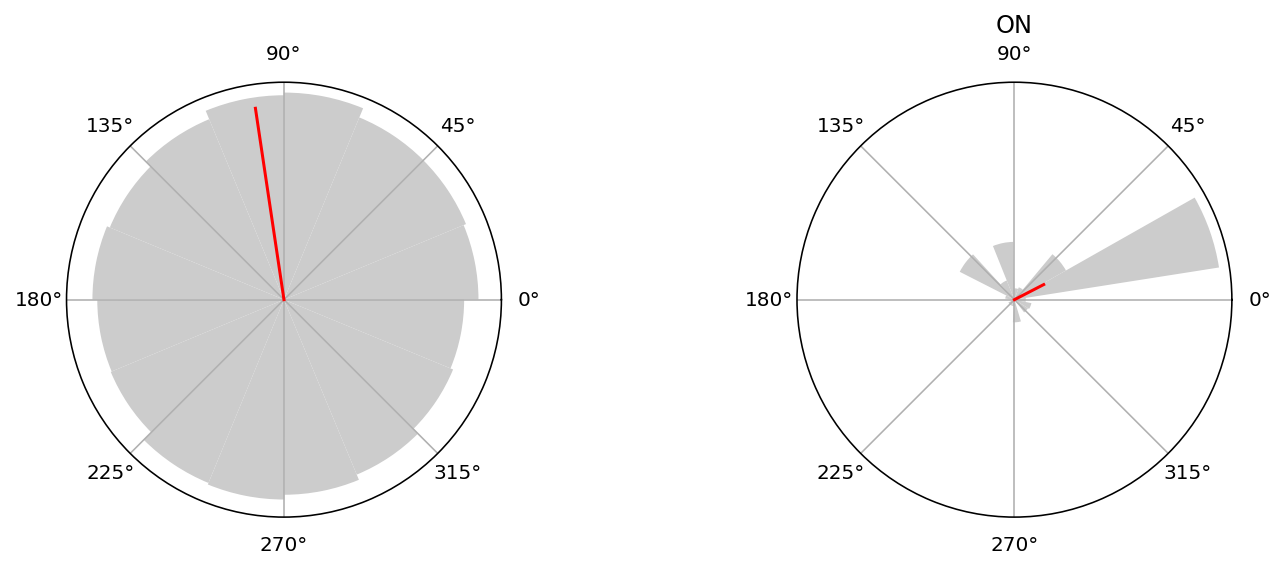

In [ ]:
# without delay, together with the following parameters, we can get the beta oscillation
# time stepsize for simulation

dt = 0.001

t = np.arange(0,1.5,dt)

delay_EE=int(0.006/dt)
delay_EI=int(0.02/dt)     # sensitive to E phase, right
delay_IE=int(0.001/dt)
delay_II=int(0.03/dt)    #sensitive to I phase, right   


# External input

wEE=0.99
wEI=0.592
wIE=0.374
# wIE=0.001
wII=11.2

# Excitatory parameters
tau_E = 0.004   # sensitive to the amplitude of the peak frequency

# Inhibitory parameters
tau_I = 0.018
r=0

a_E=16
theta_E=6
a_I=25
theta_I=5    #sensitive to the firing rate of I

tau0 = 0.002 # Noise time constant [sec]
sigma = 0.02 # Noise magnitude [nA]
I_noise= 1 # background current [nA]

I_extE = -5.5
I_extI = -5.5
E0=np.linspace(0,1,100)
I0=np.linspace(0,1,100)
E_phases_stim,I_phases_stim=plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2)

I_extE = -6.5
I_extI = -9
E_spon,I_spon,LFP_spon,beta_LFP_spon=simulate_wc(t,0,0)
E_phases_spon,I_phases_spon=plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2)

fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,4))
plt.title('OFF')
circular_hist(axs[0], I_phases_spon, offset = 0)
circular_hist(axs[1], I_phases_stim, offset = 0)
plt.title('ON')



(array([ 83,  73,  71,  74,  68,  66,  64,  63,  66,  56,  58, 512, 342,
         69,  62,  72]),
 array([-3.13941911e+00, -2.74691283e+00, -2.35440654e+00, -1.96190026e+00,
        -1.56939398e+00, -1.17688769e+00, -7.84381407e-01, -3.91875123e-01,
         6.31160630e-04,  3.93137445e-01,  7.85643729e-01,  1.17815001e+00,
         1.57065630e+00,  1.96316258e+00,  2.35566886e+00,  2.74817515e+00,
         3.14068143e+00]),
 <BarContainer object of 16 artists>)

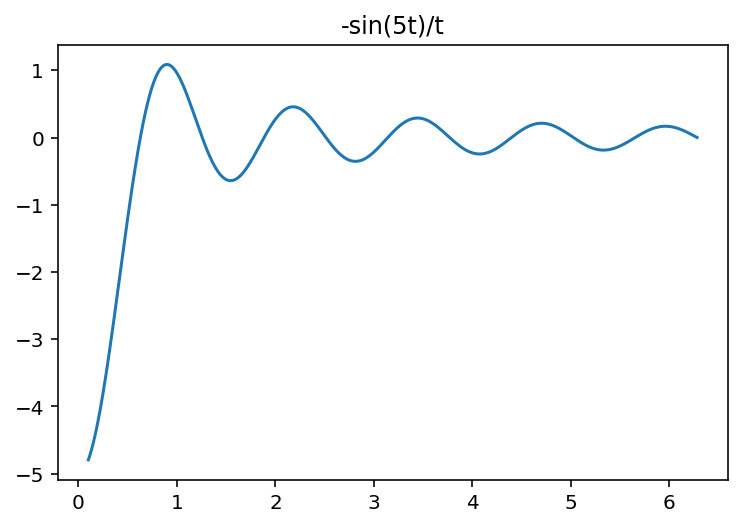

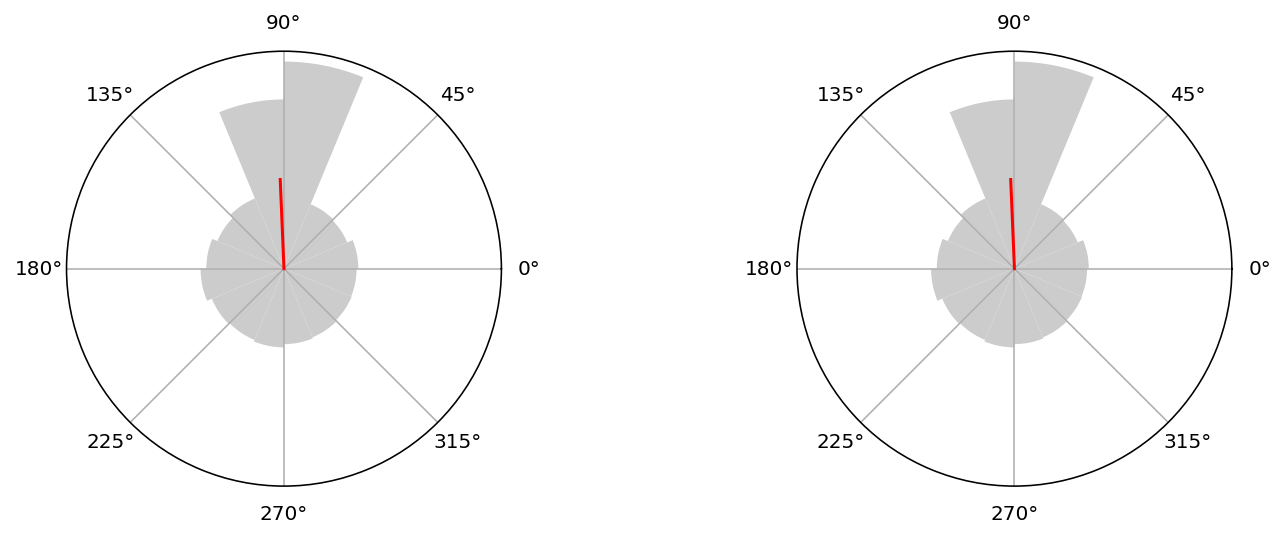

In [ ]:
# a=2*np.ones(1000)+np.random.normal(0,1,1000)
N=2000
t=np.linspace(0.1,2*np.pi,N)
# a=-0.5*np.ones(200)+np.random.normal(0,0.1,200)
a=-np.sin(5*t)/t
tant=(np.cos(t)+np.cos(2*t))/(np.sin(t)+np.sin(2*t))
plt.plot(t,a)
# plt.plot(tant)
plt.title('-sin(5t)/t')
# a_HT=hilbert(a)
beta_LFP=beta_LFP+np.random.normal(0,1,len(beta_LFP))
phase=get_phase(beta_LFP[200:-1],np.arange(len(beta_LFP[200:-1])))
fig, axs = plt.subplots(1,2, subplot_kw = dict(projection = 'polar'),figsize=(12,4))
circular_hist(axs[0], phase, offset = 0)
circular_hist(axs[1], phase, offset = 0)

63.04262863222425
[19.87447352]


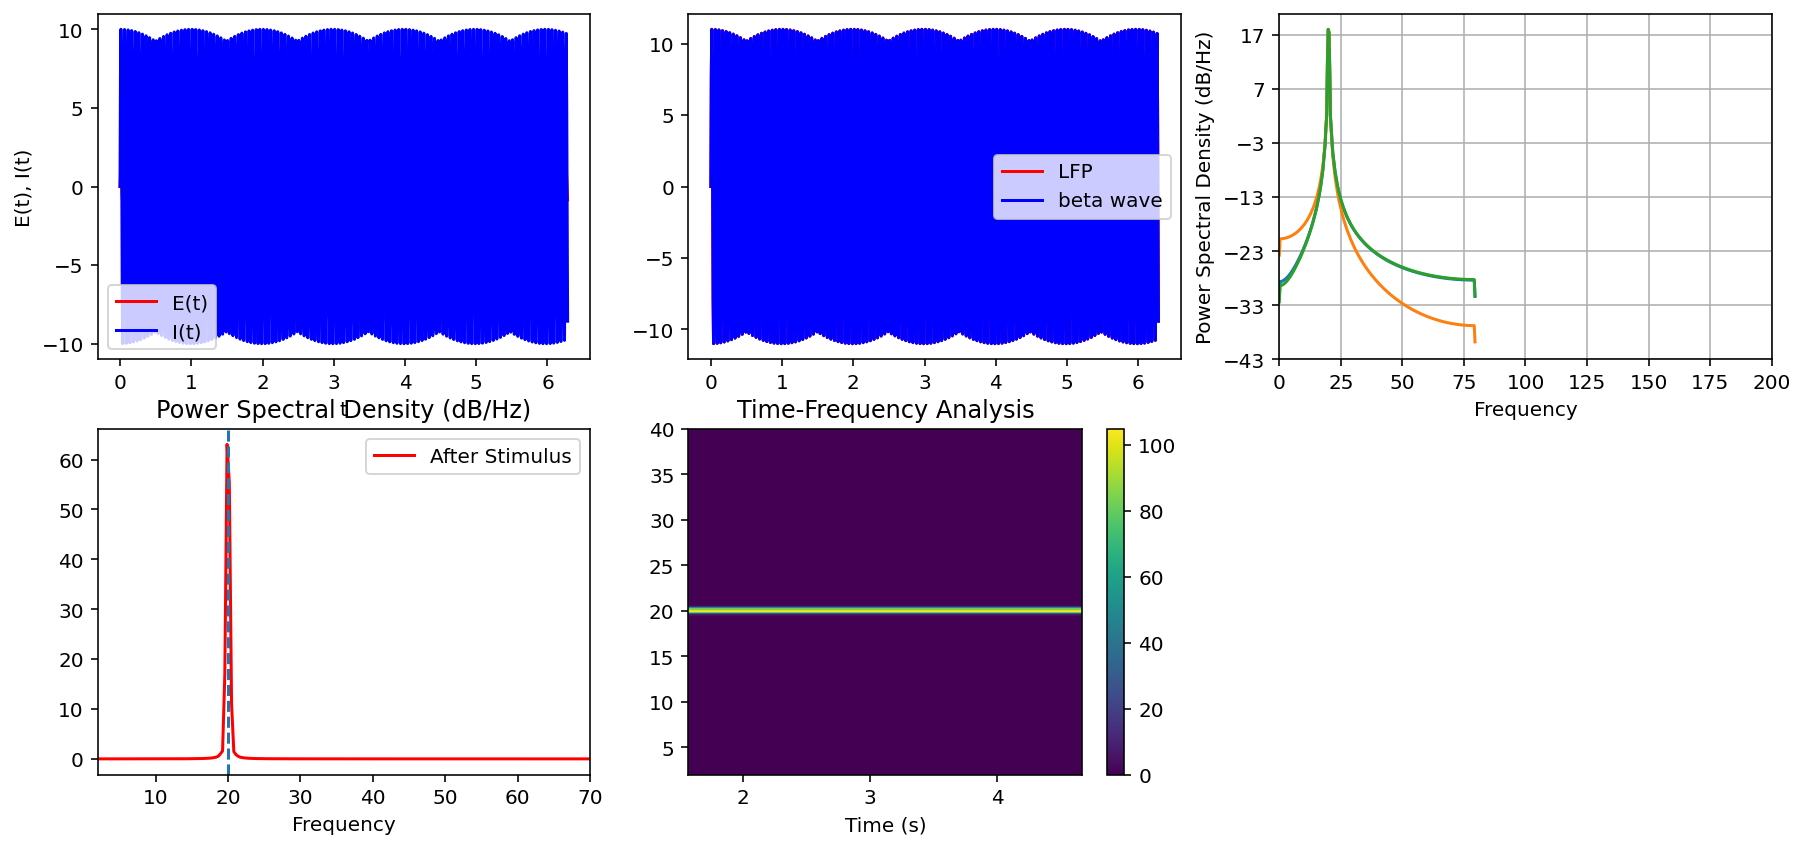

In [ ]:
t=np.linspace(0,2*np.pi,1000)
E=np.sin(2*np.pi*20*t)
I=10*np.sin(2*np.pi*20*t)
frequency_analysis(t,E,I,E+I,E+I)

5521459.827530839
[11.71875]


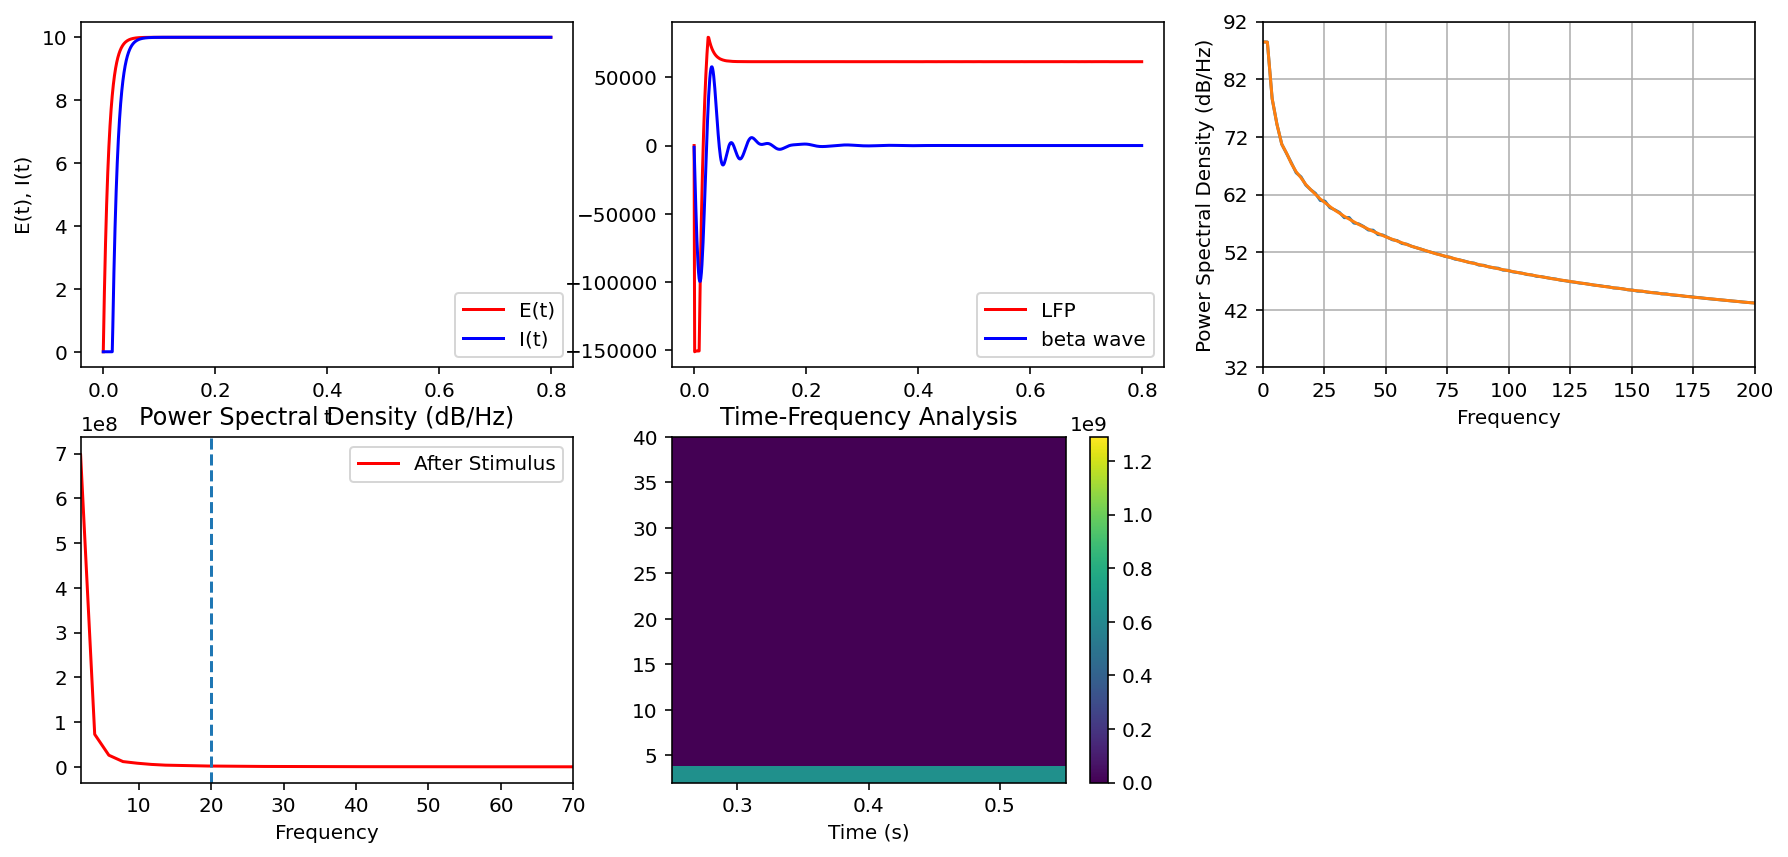

In [ ]:
# STN,GP population parameters
# synaptic delay of the population 
dt = 0.001       # ms

# delay_EE=int(0.006/dt)   #unit ms
# delay_EI=int(0.005/dt)   # clockwise
# delay_IE=int(0.004/dt)
# delay_II=int(0.006/dt)

# # # External input healthy state
# # K=0
# # I_extE = 27*2.42
# # I_extI = -2*15.1

# # disease state
# # K=1
# # I_extE = 27*9.2
# # I_extI = -2*139.4


# # wEE = 6    #frequency decrease
# # wEI = 1.12 + K*(10.7-1.12)
# # wIE = 19.0 + K*(20.0-19.0)
# # wII = 6.60 + K*(12.3-6.60)
# # Excitatory parameters
# tau_E = 0.006      # Timescale of excitatory population

# # Inhibitory parameters
# tau_I = 0.014    # Timescale of inhibitory population
# r=0

# a_E=300
# theta_E=17
# a_I=400
# theta_I=75    #sensitive to the firing rate of I

tau0 = 0.002 # Noise time constant [sec]
sigma = 0.02 # Noise magnitude [nA]
I_noise= 1 # background current [nA]

I_extE = 27*9.2
I_extI = -2*139.4

tau_E = 0.01
tau_I=0.01
delt=0.8*tau_I

delay_EE=int(delt/dt)   #unit ms
delay_EI=int(delt/dt)   # clockwise
delay_IE=int(delt/dt)
delay_II=int(delt/dt)

wEE = 0    #frequency decrease
wEI = 3
wIE = 50
wII = 12.3

a_E=10
theta_E=1.7
a_I=10
theta_I=1.7    #sensitive to the firing rate of I



# plot_phase()

t = np.arange(0,0.8,dt)
E,I,LFP,beta_LFP = simulate_wc(t,0,0)
frequency_analysis(t,E,I,LFP,beta_LFP)
E0=[0]
I0=[0]
t = np.arange(0,2,dt)
# plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2)

# I_input=np.arange(-200,200,1)
# phase_meanE=np.zeros((len(I_input),len(I_input)))
# phase_meanI=np.zeros((len(I_input),len(I_input)))
# for i in range(len(I_input)):
#     I_extE=I_input[i]
#     for j in range(len(I_input)):
#         I_extI=I_input[j]
#         E_phases, I_phases = plot_circular_histogram_and_plv(t,E0,I0, density = True, show_mean = True, amp=1.2)
#         E_mean = np.angle(np.exp(E_phases * 1j).mean())
#         I_mean = np.angle(np.exp(I_phases * 1j).mean())
#         phase_meanI[i,j]=np.abs(I_mean-315)
#         phase_meanE[i,j]=np.abs(E_mean-225)
# E,I,LFP,beta_LFP = simulate_wc(t,0,0)
# frequency_analysis(t,E,I,LFP,beta_LFP)
# E0=np.linspace(0,1,100)
# I0=np.linspace(0,1,100)

In [ ]:
from scipy.io import loadmat
data=loadmat('/home/wzl/LFPy/oscillation/toy model/ChAT_totol.mat')
spike=data['spike']
plt.scatter(spike[0,:],np.ones_like(spike[0,:]))

OSError: could not read bytes

/home/wzl/anaconda/envs/lfpy/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app
/home/wzl/anaconda/envs/lfpy/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


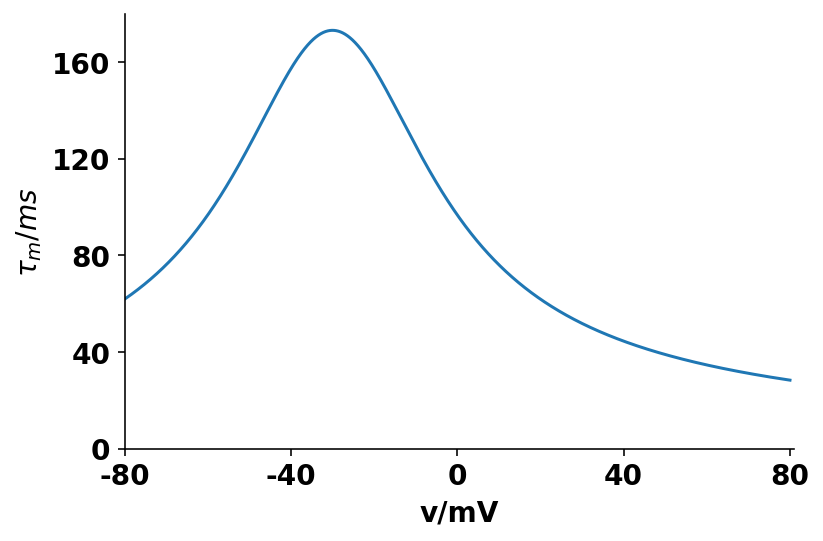

In [ ]:
font1={'family':'Times New Roman',
'weight':'bold',
'size': 14}
v=np.arange(-80,80,0.01)
qs=3.209
am=(qs*1e-4*(v+30))/(1-np.exp(-(v+30)/9))
bm=-(qs*1e-4*(v+30))/(1-np.exp((v+30)/9))
taum=(am+bm)**-1
fig,ax=plt.subplots(1,1)
ax.plot(v,taum)
ax.set_xlabel('v/mV',font1)
ax.set_ylabel(r'$\tau_m/ms$',font1)
ax.set_xticks(np.arange(-80,100,40))
ax.set_yticks(np.arange(0,200,40))
ax.set_xticklabels(np.arange(-80,100,40),font1)
ax.set_yticklabels(np.arange(0,200,40),font1)
ax.set_xlim([-80,81])
ax.set_ylim([0,180])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
